# Checking the rigorous RWA: population dynamics and spectra

In [1]:
import time

from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt

import UD_liouv as RC
import driving_liouv as EM
import exact_IB as exact
import scipy as sp

import phonon_weak_coupling as WC
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard, J_multipolar, ground_and_excited_states, initialise_TLS

import spectra_functions as SF

reload(RC)
reload(EM)
reload(exact)
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 13
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

# Things that will always be true
ev_to_inv_cm = 8065.5
inv_ps_to_inv_cm = 5.309
G = ket([0])
E = ket([1])
sigma = G*E.dag() # Definition of a sigma_- operator.
J_EM = J_multipolar#EM.J_minimal

w_RC=1700.0 | TLS splitting = 1000.0 | RC-res. coupling=0.01 | TLS-RC coupling=504.98 | Gamma_RC=100.00 | alpha_ph=95.49 | N=10 |
Calculating non-RWA Liouvilliian took 0.248788118362 seconds.
It took  0.440153837204  seconds to build the Non-secular RWA Liouvillian
It took  0.642031908035  seconds to build the vibronic Lindblad Liouvillian
10.0%. Run time:   0.46s. Est. time left: 00:00:00:04
20.0%. Run time:   0.77s. Est. time left: 00:00:00:03
30.0%. Run time:   1.10s. Est. time left: 00:00:00:02
40.0%. Run time:   1.43s. Est. time left: 00:00:00:02
50.0%. Run time:   1.75s. Est. time left: 00:00:00:01
60.0%. Run time:   2.07s. Est. time left: 00:00:00:01
70.0%. Run time:   2.41s. Est. time left: 00:00:00:01
80.0%. Run time:   2.73s. Est. time left: 00:00:00:00
90.0%. Run time:   3.08s. Est. time left: 00:00:00:00
Total run time:   3.39s
10.0%. Run time:   0.19s. Est. time left: 00:00:00:01
20.0%. Run time:   0.38s. Est. time left: 00:00:00:01
30.0%. Run time:   0.57s. Est. time left

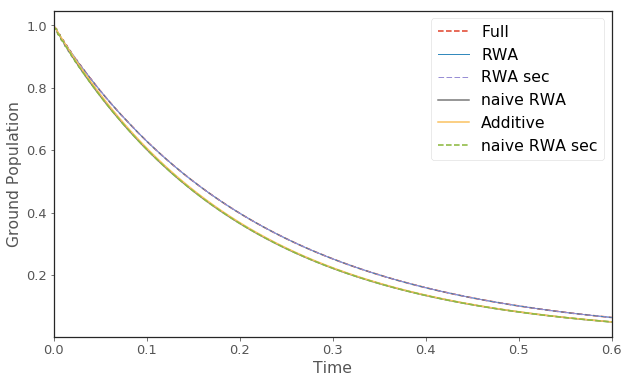

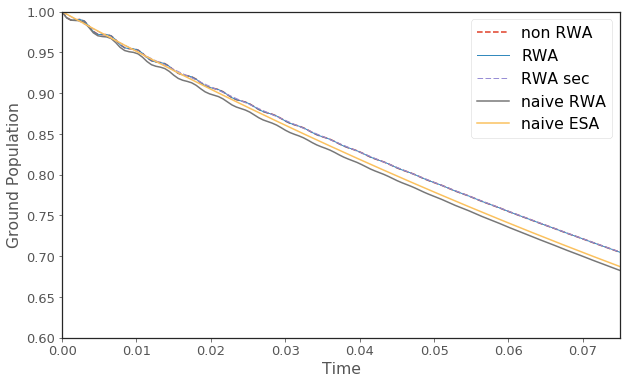

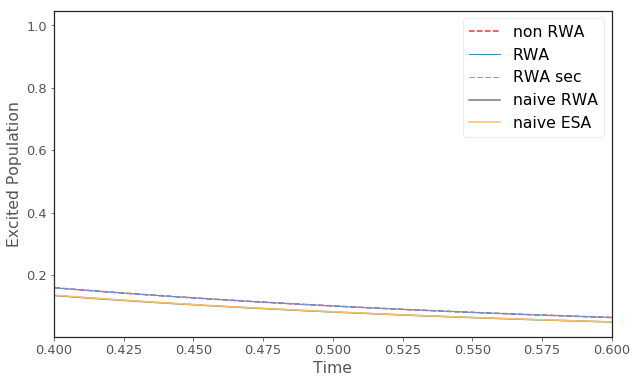

In [33]:
reload(RC)
reload(EM)
nTimeSteps = 1000
timelist = np.linspace(0, 0.60, nTimeSteps)
from qutip import basis
def dynamics_plotter(eps=1000., T_ph=300., w0_prop=0.1, alpha_prop=0.1, 
                     Gamma_prop=0.1, T_EM=0., Gamma_EM_prop=0.005, N = 25):
    
    Gamma, w0, alpha_ph, Gamma_EM = Gamma_prop*eps, w0_prop*eps, alpha_prop*eps/pi, Gamma_EM_prop*eps
    L_RC, H_RC, A_EM, A_nrwa, _, _, _, _ = RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, N)
    S_plus, S_minus, S_0 = EM.RWA_system_ops(H_RC, A_nrwa)
    k_test = tensor(basis(2,1), basis(N,0))
    hh,hhh =  S_minus*k_test, A_EM*k_test
    L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM)
    L_vib_ns = EM.L_nonsecular(H_RC, S_minus, eps, Gamma_EM, T_EM, J=J_EM).tidyup(atol=1E-9)
    L_vib_s = EM.L_vib_lindblad(H_RC, S_minus, eps, Gamma_EM, T_EM, J=J_EM).tidyup(atol=1E-9)
    L_em_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True).tidyup(atol=1E-9)
    L_em_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True).tidyup(atol=1E-9)
    
    L_em = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J_EM, silent=True)
    expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag()+G*E.dag(), qeye(N)), 
                   tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
                   tensor(qeye(2), destroy(N).dag()+destroy(N))]
    n_RC = EM.Occupation(w0, T_ph)
    rho_0 = tensor(E*E.dag(), thermal_dm(N, n_RC))
    #DATA_wc = mesolve(H_S, initial_sys, timelist, [L_wc], expects_wc, progress_bar=True)
    #print H_RC.eigenenergies()
    #print eps-0.5*np.pi*alpha, eps+w0, eps-0.5*np.pi*alpha+w0
    DATA_rig = mesolve(H_RC, rho_0, timelist, [L_RC+L_vib_ns], 
                          expects, options=qt.Options(nsteps=1000), progress_bar=True).expect[2].real
    DATA_nrwa = mesolve(H_RC, rho_0, timelist, [L_RC+L_nrwa], 
                          expects, options=qt.Options(nsteps=1000), progress_bar=True).expect[2].real
    
    DATA_rigsec = mesolve(H_RC, rho_0, timelist, [L_RC+L_vib_s], 
                          expects, options=qt.Options(nsteps=1000)).expect[2].real
    DATA_nonrig = mesolve(H_RC, rho_0, timelist, [L_RC+L_em_ns], 
                          expects, options=qt.Options(nsteps=1000)).expect[2].real
    DATA_ESA = mesolve(H_RC, rho_0, timelist, [L_RC+L_em], 
                          expects, options=qt.Options(nsteps=1000)).expect[2].real
    #DATA_nonrig_sec = mesolve(H_RC, rho_0, timelist, [L_RC+L_em_s], 
    #                      expects, options=qt.Options(nsteps=1000)).expect[2].real
    plt.figure(figsize=(10,6))
    plt.plot(timelist, DATA_nrwa, label='Full', ls='dashed', linewidth=1.6)
    plt.plot(timelist, DATA_rig, label='RWA', linewidth=1.)
    plt.plot(timelist, DATA_rigsec, label='RWA sec', ls='dashed',linewidth=1.0)
    plt.plot(timelist, DATA_nonrig, label='naive RWA')
    plt.plot(timelist, DATA_ESA, label='Additive')
    plt.xlim(timelist[0], timelist[-1])
    plt.plot(timelist, DATA_nonrig, label='naive RWA sec', ls='dashed', linewidth=1.6)
    plt.legend(loc='best')
    plt.ylabel('Ground Population')
    plt.xlabel('Time')
    plt.figure(figsize=(10,6))
    plt.plot(timelist, DATA_nrwa, label='non RWA', ls='dashed', linewidth=1.6)
    plt.plot(timelist, DATA_rig, label='RWA', linewidth=1.)
    plt.plot(timelist, DATA_rigsec, label='RWA sec', ls='dashed',linewidth=1.0)
    plt.plot(timelist, DATA_nonrig, label='naive RWA')
    plt.plot(timelist, DATA_ESA, label='naive ESA')
    plt.ylim(0.6, 1.)
    plt.xlim(0.,0.075)
    #plt.plot(timelist, DATA_nonrig, label='naive RWA sec', ls='dashed', linewidth=1.6)
    plt.legend(loc='best')
    plt.ylabel('Ground Population')
    plt.xlabel('Time')
    plt.figure(figsize=(10,6))
    plt.plot(timelist, DATA_nrwa, label='non RWA', ls='dashed', linewidth=1.6)
    plt.plot(timelist, DATA_rig, label='RWA', linewidth=1.)
    plt.plot(timelist, DATA_rigsec, label='RWA sec', ls='dashed',linewidth=1.0)
    plt.plot(timelist, DATA_nonrig, label='naive RWA')
    plt.plot(timelist, DATA_ESA, label='naive ESA')
    #plt.plot(timelist, DATA_nonrig, label='naive RWA sec', ls='dashed', linewidth=1.6)
    plt.legend(loc='best')
    plt.xlim(timelist[-1]-0.2,timelist[-1])
    plt.ylabel('Excited Population')
    plt.xlabel('Time')
    
    plt.show()
    return L_nrwa
    
#dynamics_plotter(alpha_prop=0.2, w0_prop=0.99, N=12)
#L = dynamics_plotter(alpha_prop=0.001, w0_prop=0.1, N=10)
L = dynamics_plotter(alpha_prop=0.3, w0_prop=1.7, N=10, T_EM=0.)

# RWA on the RC-residual bath interaction

We have $H_I(t) = A(t)\otimes B(T)$ where $A(t) = I_{S}\otimes (a^{\dagger} + a)$ which means that we can perform a RWA and on this Hamiltonian. As a first approximation I can just use the old code for calculating the optical liouvillians and chuck in my own spectral densities. It does pretty badly - particularly for low frequency modes. Could be worth going back to the maths and having a look if there's anything missing.

In [2]:
def RC_residual_RWA_dynamics_plotter(eps=1000., T_ph=300., w0_prop=0.1, alpha_prop=0.1, 
                     Gamma_prop=0.1, T_EM=0., Gamma_EM_prop=0.005, N = 25):
    
    Gamma, w0, alpha_ph, Gamma_EM = Gamma_prop*eps, w0_prop*eps, alpha_prop*eps, Gamma_EM_prop*eps
    L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _ = RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, N)
    c_RC = destroy(N)
    A_ph = tensor(qeye(2), c_RC+c_RC.dag())
    C_plus, C_minus, S_0 = EM.RWA_system_ops(H_RC, A_ph)
    Gamma_RC_res = Gamma / (2. * np.pi * w0)
    def J_RC(x, g, _):
        return g*x
    L_RC_ns = EM.L_nonsecular(H_RC, C_minus, eps, Gamma_RC_res, T_ph, J=J_RC)
    L_RC_s = EM.L_vib_lindblad(H_RC, C_minus, eps, Gamma_RC_res, T_ph, J=J_RC)
    #L_RC_fs = EM.L_full_secular(H_RC, C_minus, eps, Gamma_RC_res, T_ph, J=J_RC)
    expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag()+G*E.dag(), qeye(N)), 
                   tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
                   tensor(qeye(2), destroy(N).dag()+destroy(N))]
    n_RC = EM.Occupation(w0, T_ph)
    rho_0 = tensor(0.5*(G*E.dag()+E*G.dag()), thermal_dm(N, n_RC))
    timelist = np.linspace(0,0.05,300)
    DATA_1 = mesolve(H_RC, rho_0, timelist, [L_RC], 
                          expects, options=qt.Options(nsteps=1000)).expect[1].real
    DATA_2 = mesolve(H_RC, rho_0, timelist, [L_RC_ns], 
                          expects, options=qt.Options(nsteps=1000)).expect[1].real
    DATA_3 = mesolve(H_RC, rho_0, timelist, [L_RC_s], 
                          expects, options=qt.Options(nsteps=1000)).expect[1].real
    #DATA_4 = mesolve(H_RC, rho_0, timelist, [L_RC_fs], 
    #                      expects, options=qt.Options(nsteps=1000), progress_bar=True).expect[1].real
    plt.figure(figsize=(10,6))
    plt.plot(timelist, DATA_1, label='Full RC', ls='dashed', linewidth=1.6)
    plt.plot(timelist, DATA_2, label='non-sec RC', linewidth=1.)
    plt.plot(timelist, DATA_3, label='sec RC', ls='dashed',linewidth=1.0)
    #plt.plot(timelist, DATA_4, label='proper sec RC')
    plt.legend(loc='best')
    plt.ylabel('Ground Population')
    plt.xlabel('Time')
    plt.show()

RC_residual_RWA_dynamics_plotter(T_ph=100., alpha_prop=0.2, w0_prop=0.99,Gamma_prop=0.1, N=15)
RC_residual_RWA_dynamics_plotter(T_ph=100., alpha_prop=0.2, w0_prop=0.99,Gamma_prop=0.2, N=15)
RC_residual_RWA_dynamics_plotter(T_ph=100., alpha_prop=0.2, w0_prop=0.1,Gamma_prop=0.2, N=20)


w_RC=990.0 | TLS splitting = 1000.0 | RC-res. coupling=0.02 | TLS-RC coupling=557.69 | Gamma_RC=100.00 | alpha_ph=200.00 | N=15 |
It took  1.19549107552  seconds to build the Non-secular RWA Liouvillian
It took  2.46312189102  seconds to build the vibronic Lindblad Liouvillian


KeyboardInterrupt: 

In [55]:
reload(SF)
def power_emitted(spec):
    return sum(spec[0]), sum(spec[1])

def power_emitted_vs_T(alpha_prop, eps, Gamma, w0_prop=0.1, T_EM=0., 
                         Gamma_EM=Gamma_EM, overdamped=False, 
                         N=12, end_T_mult=7., rotating=False, 
                         tau_f_mult=2.5, T_increments=20, 
                         nsteps=3000, method='bdf', order=5):
    powers = []
    T_values = [20., 30., 50, 77., 120., 200., 300.]
    for T in T_values:
        times, pops, taus, g1, specs, freqs = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, 
                                                     w0_prop=w0_prop, T_ph=T, T_EM=0., 
                                                     Gamma_EM=Gamma_EM, overdamped=overdamped, 
                                                     N=N, end_T_mult=end_T_mult, rotating=rotating, 
                                                     tau_f_mult=tau_f_mult, T_increments=T_increments, 
                                                     nsteps=nsteps, method=method, 
                                                    order=order, normalise=False, silent=True)
        powers.append(power_emitted(specs))
    powers = zip(*powers)
    naPower = np.array(powers[0])/powers[0][0]
    aPower = np.array(powers[1])/powers[1][0]
    return T_values, naPower, aPower

eps = 8000.
w0_prop = 400/eps
alpha_prop = pi*800/eps
Gamma = 80.
Gamma_EM = (10/100.)/inv_ps_to_inv_cm

T, naP, aP = power_emitted_vs_T(alpha_prop, eps, Gamma, 
                       w0_prop=w0_prop, T_ph=300., T_EM=0., 
                       Gamma_EM=Gamma_EM, overdamped=False, 
                       N=10, end_T_mult=7., rotating=True, 
                       tau_f_mult=2.5, T_increments=9, 
                       nsteps=3000, method='bdf', order=5)

w_RC=400.0 | TLS splitting = 8000.0 | RC-res. coupling=0.03 | TLS-RC coupling=708.98 | Gamma_RC=80.00 | alpha_ph=800.00 | N=10 |
final t:  371.63
10.0%. Run time:  44.05s. Est. time left: 00:00:06:35
20.0%. Run time:  88.08s. Est. time left: 00:00:05:52
30.0%. Run time: 126.79s. Est. time left: 00:00:04:55
40.0%. Run time: 165.84s. Est. time left: 00:00:04:08
50.0%. Run time: 203.16s. Est. time left: 00:00:03:23
60.0%. Run time: 241.08s. Est. time left: 00:00:02:40
70.0%. Run time: 281.43s. Est. time left: 00:00:02:00
80.0%. Run time: 320.86s. Est. time left: 00:00:01:20
90.0%. Run time: 358.65s. Est. time left: 00:00:00:39
Total run time: 395.22s
Completed initial dynamics calculations for Full in 395.633387804  seconds.
Completed correlation function calculations for Full in 8.38924694061 seconds.
10.0%. Run time:  41.34s. Est. time left: 00:00:06:11
20.0%. Run time:  78.97s. Est. time left: 00:00:05:15
30.0%. Run time: 117.27s. Est. time left: 00:00:04:33
40.0%. Run time: 154.11s. E

10.0%. Run time:  39.91s. Est. time left: 00:00:05:58
20.0%. Run time:  83.90s. Est. time left: 00:00:05:35
30.0%. Run time: 127.10s. Est. time left: 00:00:04:56
40.0%. Run time: 184.24s. Est. time left: 00:00:04:36
50.0%. Run time: 223.67s. Est. time left: 00:00:03:43
60.0%. Run time: 265.35s. Est. time left: 00:00:02:56
70.0%. Run time: 314.26s. Est. time left: 00:00:02:14
80.0%. Run time: 366.58s. Est. time left: 00:00:01:31
90.0%. Run time: 406.93s. Est. time left: 00:00:00:45
Total run time: 447.47s
Completed initial dynamics calculations for Naive in 448.023159027  seconds.
Completed correlation function calculations for Naive in 12.5067260265 seconds.
w_RC=400.0 | TLS splitting = 8000.0 | RC-res. coupling=0.03 | TLS-RC coupling=708.98 | Gamma_RC=80.00 | alpha_ph=800.00 | N=10 |
final t:  371.63
10.0%. Run time:  49.41s. Est. time left: 00:00:07:23
20.0%. Run time:  88.47s. Est. time left: 00:00:05:53
30.0%. Run time: 134.54s. Est. time left: 00:00:05:13
40.0%. Run time: 185.61s.

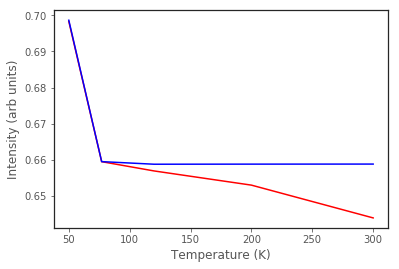

In [59]:

plt.plot(T[2:], naP[2:], color='r')
plt.plot(T[2:], aP[2:], color='b')
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity (arb units)")
plt.show()

In [64]:

def power_emitted(init_sys, init_RC, prop_coupling, eps, Gamma, w0_prop=2.1,
                    T_ph=300., T_EM=0.,Gamma_EM=1., overdamped=False, N=9,
                    end_T_mult=10,  rotating=False,
                    T_increments=9, nsteps=2000, method='adams', order=12,
                    normalise=True, silent=False
                    ):
    # Start system+RC in adiabatic eigenstate and then time-evolve
    alpha_ph = prop_coupling*eps/pi
    w0 = eps*w0_prop
    if overdamped:
        wc = 53.
        Gamma = (w0**2)/wc
    if not silent:
        w = np.linspace(0., eps*1.5, 1000)
        plt.figure()
        plt.plot(w, J_underdamped(w, alpha_ph, Gamma, w0))
        plt.axvline(eps, label='Splitting',color='k')
        plt.ylabel("Coupling Strength")
        plt.xlabel(r"Frequency $cm^{-1}$")
        plt.title("Phonon Spectral Density")
        plt.legend()
        plt.show()
    G, E = ket([0]), ket([1])
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = J_multipolar
    count = 1
    I_RC = qt.qeye(N)
    # This is true for specific Hamiltonian parameters

    L_RC, H_RC, A_EM, A_nrwa, Z, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps,
                                                        T_ph, Gamma,
                                                        w0, alpha_ph,
                                                        N, rotating=rotating)
    H_RC_opt = RC.Ham_RC(sigma, eps, w0, kappa, N, rotating=False)[0]
    evals, states = H_RC.eigenstates()
    ground_list, excited_list = ground_and_excited_states(states)
    # work out how to initialise system rho
    init_rho = initialise_TLS(init_sys, init_RC, states, w0, T_ph)

    # electromagnetic bath liouvillians
    final_t = end_T_mult/Gamma_EM
    print "final t: ", final_t
    timelist = np.linspace(0, final_t, int(T_increments*final_t))
    options = qt.Options(nsteps=nsteps, store_states=True, 
                                method=method, order=order)
    E_op = tensor(E*E.dag(), I_RC)
    #
    power_list = []
    
    #EM.L_non_rwa(H_RC_opt, A_nrwa, eps, Gamma_EM, T_EM, J, silent=True)]
    label = [ 'Full','Naive']
    for i, L_EM in enumerate([EM.L_non_rwa(H_RC_opt, A_nrwa, eps, Gamma_EM,
                            T_EM, J, silent=True),
                             EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM,
                             J=J, silent=True)]):
        ti = time.time()
        sigma_RC = tensor(sigma, I_RC)

        if i==0:
            sigma_plus_RC, sigma_RC, sigma_0_RC = EM.RWA_system_ops(H_RC_opt,
                                                tensor(sigma+sigma.dag(), I_RC))
        P = mesolve(H_RC, init_rho, timelist, [L_RC+L_EM], progress_bar=True,
                                                        options=options).states
        pop = [((E_op*p).tr()).real for p in P]
        power_list.append(sum(pop))
    return power_list

def power_emitted_vs_T(alpha_prop, eps, Gamma, w0_prop=0.1, T_EM=0., 
                         Gamma_EM=Gamma_EM, overdamped=False, 
                         N=12, end_T_mult=7., rotating=False, 
                         tau_f_mult=2.5, T_increments=20, 
                         nsteps=3000, method='bdf', order=5):
    powers = []
    T_values = [20., 30., 50, 77., 120., 200., 300.]
    for T in T_values:
        power_list = power_emitted(2, 0, alpha_prop, eps, Gamma, 
                                 w0_prop=w0_prop, T_ph=T, T_EM=0., 
                                 Gamma_EM=Gamma_EM, overdamped=overdamped, 
                                 N=N, end_T_mult=end_T_mult, rotating=rotating, 
                                T_increments=T_increments, 
                                 nsteps=nsteps, method=method, 
                                order=order, normalise=False, silent=True)
        powers.append(power_emitted(specs))
    powers = zip(*powers)
    naPower = np.array(powers[0])/powers[0][0]
    aPower = np.array(powers[1])/powers[1][0]
    return T_values, naPower, aPower

eps = 8000.
w0_prop = 400/eps
alpha_prop = pi*800/eps
Gamma = 80.
Gamma_EM = (10/100.)/inv_ps_to_inv_cm

T, naP, aP = power_emitted_vs_T(alpha_prop, eps, Gamma, 
                       w0_prop=w0_prop, T_EM=0., 
                       Gamma_EM=Gamma_EM, overdamped=False, 
                       N=10, rotating=True, T_increments=9, 
                       nsteps=3000, method='bdf', order=5)

w_RC=400.0 | TLS splitting = 8000.0 | RC-res. coupling=0.03 | TLS-RC coupling=708.98 | Gamma_RC=80.00 | alpha_ph=800.00 | N=10 |
final t:  371.63
10.0%. Run time:  38.64s. Est. time left: 00:00:05:47
20.0%. Run time:  75.89s. Est. time left: 00:00:05:03
30.0%. Run time: 112.51s. Est. time left: 00:00:04:22
40.0%. Run time: 150.46s. Est. time left: 00:00:03:45
50.0%. Run time: 191.39s. Est. time left: 00:00:03:11
60.0%. Run time: 230.86s. Est. time left: 00:00:02:33
70.0%. Run time: 270.61s. Est. time left: 00:00:01:55
80.0%. Run time: 309.95s. Est. time left: 00:00:01:17
90.0%. Run time: 348.62s. Est. time left: 00:00:00:38
Total run time: 386.82s
10.0%. Run time:  34.24s. Est. time left: 00:00:05:07
20.0%. Run time:  68.36s. Est. time left: 00:00:04:33
30.0%. Run time: 102.76s. Est. time left: 00:00:03:59
40.0%. Run time: 137.48s. Est. time left: 00:00:03:26
50.0%. Run time: 173.00s. Est. time left: 00:00:02:53
60.0%. Run time: 207.34s. Est. time left: 00:00:02:18
70.0%. Run time: 241

TypeError: power_emitted() takes at least 5 arguments (1 given)

0.0188359389716


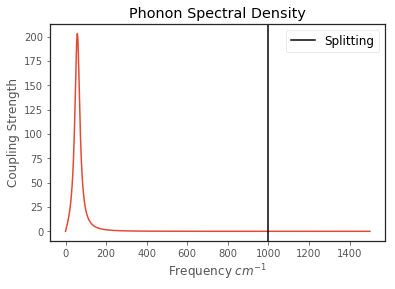

w_RC=60.0 | TLS splitting = 1000.0 | RC-res. coupling=0.08 | TLS-RC coupling=97.08 | Gamma_RC=30.00 | alpha_ph=100.00 | N=12 |
final t:  371.63
10.0%. Run time:  24.28s. Est. time left: 00:00:03:38
20.0%. Run time:  48.23s. Est. time left: 00:00:03:12
30.0%. Run time:  72.33s. Est. time left: 00:00:02:48
40.0%. Run time:  96.43s. Est. time left: 00:00:02:24
50.0%. Run time: 120.43s. Est. time left: 00:00:02:00
60.0%. Run time: 144.85s. Est. time left: 00:00:01:36
70.0%. Run time: 175.27s. Est. time left: 00:00:01:15
80.0%. Run time: 202.15s. Est. time left: 00:00:00:50
90.0%. Run time: 232.37s. Est. time left: 00:00:00:25
Total run time: 260.31s
Completed initial dynamics calculations for Full in 261.184327126  seconds.
Completed correlation function calculations for Full in 7.1953959465 seconds.
10.0%. Run time:  23.07s. Est. time left: 00:00:03:27
20.0%. Run time:  45.11s. Est. time left: 00:00:03:00
30.0%. Run time:  66.96s. Est. time left: 00:00:02:36
40.0%. Run time:  88.96s. Est.

NameError: name 'power_emitted' is not defined

In [7]:
reload(SF)
eps = 1000.
w0_prop = 60/eps
alpha_prop = pi*100/eps
Gamma = 30.
Gamma_EM = (10/100.)/inv_ps_to_inv_cm
print Gamma_EM 
times, pops, taus, g1, specs, freqs = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, 
                                                     w0_prop=w0_prop, T_ph=300., T_EM=0., 
                                                     Gamma_EM=Gamma_EM, overdamped=False, 
                                                     N=12, end_T_mult=7., rotating=False, 
                                                     tau_f_mult=2.5, T_increments=20, 
                                                     nsteps=3000, method='bdf', order=5, normalise=False)


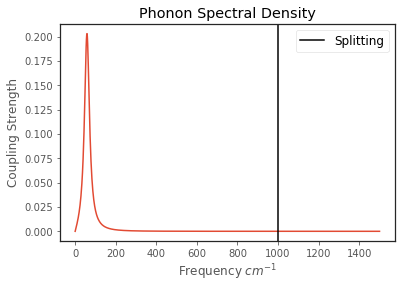

w_RC=60.0 | TLS splitting = 1000.0 | RC-res. coupling=0.08 | TLS-RC coupling=3.07 | Gamma_RC=30.00 | alpha_ph=0.10 | N=4 |
final t:  371.63
10.0%. Run time:   0.88s. Est. time left: 00:00:00:07
20.0%. Run time:   1.62s. Est. time left: 00:00:00:06
30.0%. Run time:   2.37s. Est. time left: 00:00:00:05
40.0%. Run time:   3.07s. Est. time left: 00:00:00:04
50.0%. Run time:   3.76s. Est. time left: 00:00:00:03
60.0%. Run time:   4.57s. Est. time left: 00:00:00:03
70.0%. Run time:   5.55s. Est. time left: 00:00:00:02
80.0%. Run time:   6.24s. Est. time left: 00:00:00:01
90.0%. Run time:   6.92s. Est. time left: 00:00:00:00
Total run time:   7.60s
Completed initial dynamics calculations for Full in 8.32778692245  seconds.
Completed correlation function calculations for Full in 3.61590003967 seconds.
10.0%. Run time:   0.66s. Est. time left: 00:00:00:05
20.0%. Run time:   1.33s. Est. time left: 00:00:00:05
30.0%. Run time:   1.98s. Est. time left: 00:00:00:04
40.0%. Run time:   2.64s. Est. ti

In [14]:
alpha_prop = pi*0.1/eps
times, pops, taus, g1, specs, freqs = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, 
                                                     w0_prop=w0_prop, T_ph=300., T_EM=0., 
                                                     Gamma_EM=Gamma_EM, overdamped=False, 
                                                     N=4, end_T_mult=7., rotating=False, 
                                                     tau_f_mult=2.5, T_increments=20, 
                                                     nsteps=3000, method='bdf', order=5, normalise=False)

In [15]:
print power_emitted(specs[0]), power_emitted(specs[1])

6974.69606378 6976.04352213


## TODO: Rate differences between Full, RWA and non-rigorous RWA


## Emission Spectra

In [2]:

def plot_spectra(timelist, pops, taulist, g1s, specs, freqs,
                freq_window=1000., tau_window=2.):
    plt.close('all')
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
    f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14,6))
    label = ['Full', 'Naive']
    ls = ['dashed', 'solid']
    for i, spec in enumerate(specs):
        g_1  = g1s[i]
        freq = freqs[i]
        ax1.plot(timelist, pops[i],
                label=label[i], linestyle=ls[i])
        ax3.plot(taulist[0:int(len(taulist)/tau_window)],
                 g_1.real[0:int(len(taulist)/tau_window)], 
                 label=label[i], linestyle=ls[i])
        ax4.plot(taulist[0:int(len(taulist)/tau_window)],
                 g_1.imag[0:int(len(taulist)/tau_window)], 
                 label=label[i], linestyle=ls[i])
        ax2.plot(freq, spec, label=label[i], linestyle=ls[i])
    ax1.set_xlim(0,timelist[-1])
    #ax3.set_xlim(0,taulist[int((len(taulist)-1)/5.)])
    #ax4.set_xlim(0,taulist[int((len(taulist)-1)/5.)])
    ax1.set_xlabel(r"Time")
    ax2.set_xlabel(r"Frequency $cm^{-1}$")
    #ax2.axvline(eps, linestyle='dashed',color='k', alpha=0.4)
    ax2.set_xlim(-freq_window,freq_window)

    ax1.set_ylabel(r"Excited state population")
    ax2.set_ylabel(r"Fluorescence intensity (arb. units)")
    ax3.set_ylabel(r"$Re[g_1(\tau)]$") # coherence
    ax4.set_ylabel(r"$Im[g_1(\tau)]$") # coherence
    ax3.set_xlabel(r"$\tau$")
    ax4.set_xlabel(r"$\tau$")
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.show()

0.00530871


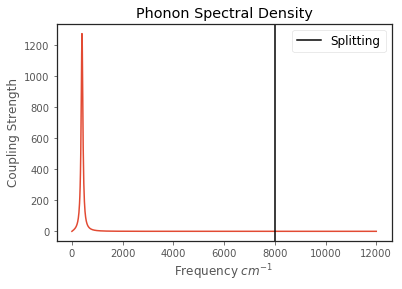

w_RC=400.0 | TLS splitting = 8000.0 | RC-res. coupling=0.03 | TLS-RC coupling=400.00 | Gamma_RC=80.00 | alpha_ph=254.65 | N=12 |
final t:  1318.58775484
10.0%. Run time:  85.94s. Est. time left: 00:00:12:53
20.0%. Run time: 169.09s. Est. time left: 00:00:11:16
30.0%. Run time: 254.50s. Est. time left: 00:00:09:53
40.0%. Run time: 338.30s. Est. time left: 00:00:08:27
50.0%. Run time: 423.38s. Est. time left: 00:00:07:03
60.0%. Run time: 507.45s. Est. time left: 00:00:05:38
70.0%. Run time: 592.58s. Est. time left: 00:00:04:13
80.0%. Run time: 677.84s. Est. time left: 00:00:02:49
90.0%. Run time: 761.74s. Est. time left: 00:00:01:24
Total run time: 846.53s
Completed initial dynamics calculations for Full in 848.29649806  seconds.
Completed correlation function calculations for Full in 12.5458419323 seconds.
10.0%. Run time:  86.29s. Est. time left: 00:00:12:56
20.0%. Run time: 176.94s. Est. time left: 00:00:11:47
30.0%. Run time: 261.92s. Est. time left: 00:00:10:10
40.0%. Run time: 350.

In [3]:
reload(SF)


eps = 8000.
w0_prop = 400/eps
alpha_prop = 800/eps
Gamma = 80.
Gamma_EM = 0.00530871
print Gamma_EM 
times, pops, taus, g1, specs, freqs = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, 
                                                     w0_prop=w0_prop, T_ph=300., T_EM=0., 
                                                     Gamma_EM=Gamma_EM, overdamped=False, 
                                                     N=12, end_T_mult=7., rotating=True, 
                                                     tau_f_mult=2.5, T_increments=9, 
                                                     nsteps=3000, method='bdf', order=5)


In [8]:
with open('spectrum.dat', 'w') as f:
    f.write(str(specs[0]))
with open('freq.dat', 'w') as f:
    f.write(str(freqs[0]))

In [5]:
specs

[(3.1345986748446762e-10,
  3.1452965619835905e-10,
  3.156015437528546e-10,
  3.1667555360630121e-10,
  3.1775167712701836e-10,
  3.1882990213153364e-10,
  3.1991025591908532e-10,
  3.2099271571277486e-10,
  3.2207727862160889e-10,
  3.2316396040150169e-10,
  3.2425275211102349e-10,
  3.2534365372952439e-10,
  3.2643667566458083e-10,
  3.2753180158207971e-10,
  3.2862904713468569e-10,
  3.29728417959836e-10,
  3.3082989130128209e-10,
  3.3193348171724107e-10,
  3.3303919439085117e-10,
  3.3414702184682929e-10,
  3.3525697891184197e-10,
  3.3636904216884214e-10,
  3.3748323650102349e-10,
  3.3859956112368785e-10,
  3.3971800595965793e-10,
  3.4083857767886871e-10,
  3.419612681452386e-10,
  3.4308611673822856e-10,
  3.4421309012881384e-10,
  3.4534219354143276e-10,
  3.4647344529259388e-10,
  3.4760683036978106e-10,
  3.4874236669715388e-10,
  3.4988004857532512e-10,
  3.5101987550869602e-10,
  3.5216186250978252e-10,
  3.5330600286734985e-10,
  3.5445230149608689e-10,
  3.556007703110

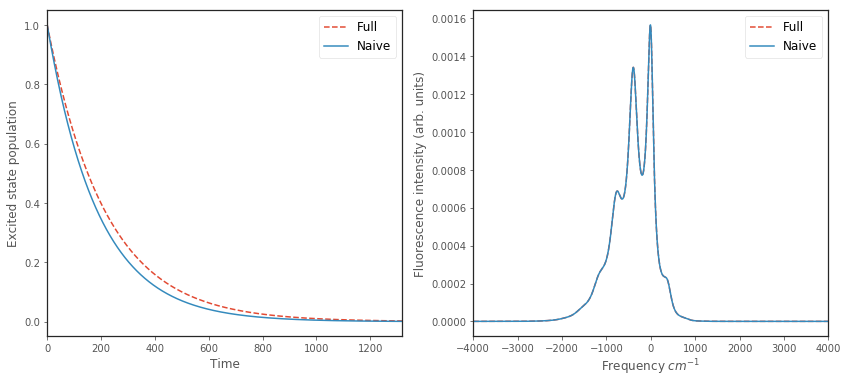

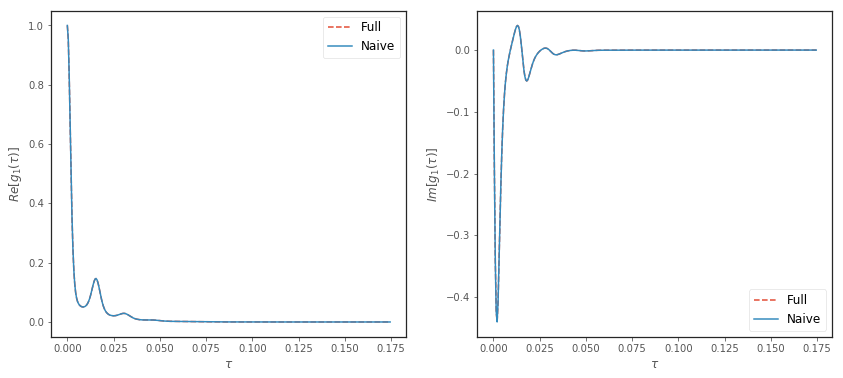

In [4]:
plot_spectra(times, pops, taus, g1, specs, freqs, freq_window=4000., tau_window=30.)

0.0188359389716


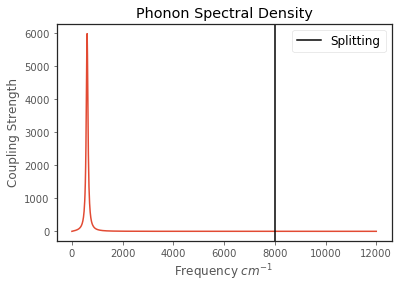

w_RC=600.0 | TLS splitting = 8000.0 | RC-res. coupling=0.02 | TLS-RC coupling=868.32 | Gamma_RC=80.00 | alpha_ph=800.00 | N=12 |
final t:  371.63
10.0%. Run time:  59.43s. Est. time left: 00:00:08:53
20.0%. Run time: 121.00s. Est. time left: 00:00:08:03
30.0%. Run time: 181.47s. Est. time left: 00:00:07:02
40.0%. Run time: 246.07s. Est. time left: 00:00:06:08
50.0%. Run time: 309.74s. Est. time left: 00:00:05:09
60.0%. Run time: 378.82s. Est. time left: 00:00:04:12
70.0%. Run time: 446.45s. Est. time left: 00:00:03:11
80.0%. Run time: 512.79s. Est. time left: 00:00:02:08
90.0%. Run time: 573.47s. Est. time left: 00:00:01:03
Total run time: 634.24s
Completed initial dynamics calculations for Full in 634.75899291  seconds.
Completed correlation function calculations for Full in 22.9273068905 seconds.
10.0%. Run time:  45.21s. Est. time left: 00:00:06:46
20.0%. Run time:  90.07s. Est. time left: 00:00:06:00
30.0%. Run time: 135.28s. Est. time left: 00:00:05:15
40.0%. Run time: 180.30s. Es

In [163]:
reload(SF)


eps = 8000.
w0_prop = 600/eps
alpha_prop = pi*800/eps
Gamma = 80.
Gamma_EM = (10/100.)/inv_ps_to_inv_cm
print Gamma_EM 
times, pops, taus, g1, specs, freqs = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, 
                                                     w0_prop=w0_prop, T_ph=300., T_EM=0., 
                                                     Gamma_EM=Gamma_EM, overdamped=False, 
                                                     N=12, end_T_mult=7., rotating=True, 
                                                     tau_f_mult=2.5, T_increments=9, 
                                                     nsteps=3000, method='bdf', order=5)

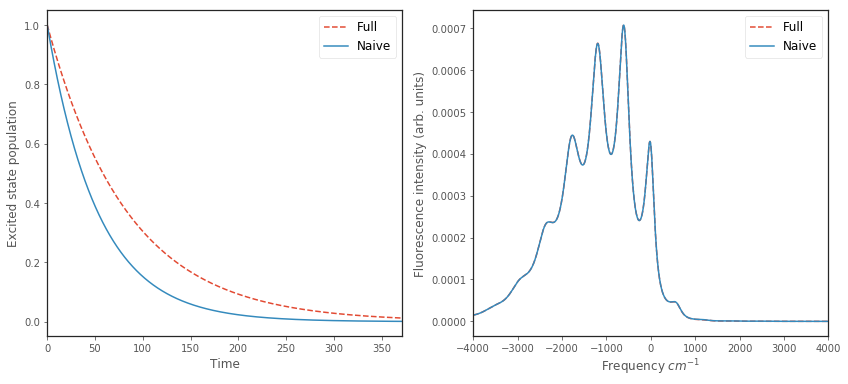

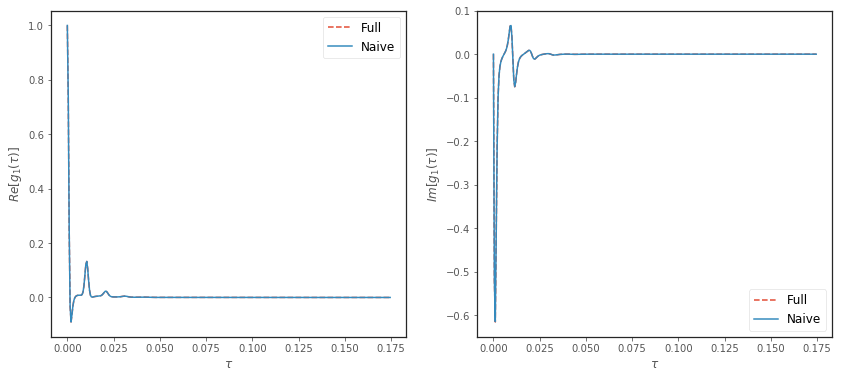

In [171]:
plot_spectra(times, pops, taus, g1, specs, freqs, freq_window=4000., tau_window=30.)

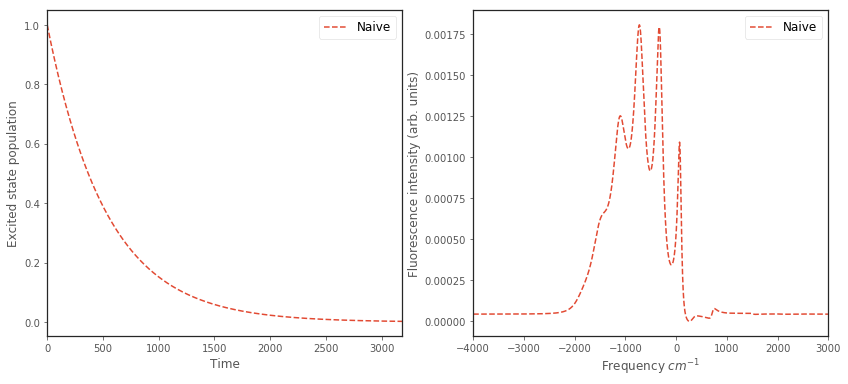

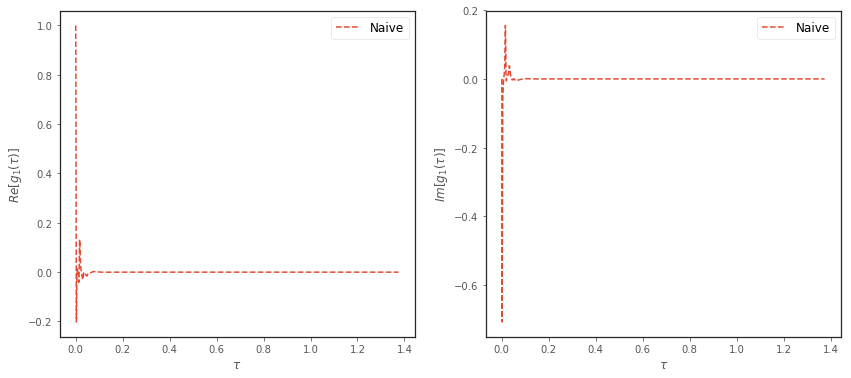

eps is 20.0 times the RC freq
1.0


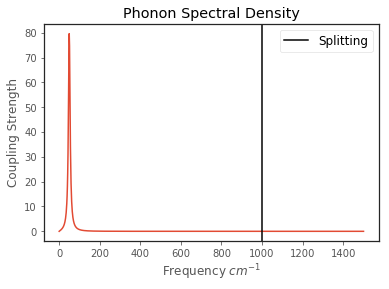

w_RC=50.0 | TLS splitting = 1000 | RC-res. coupling=0.03 | TLS-RC coupling=35.36 | Gamma_RC=10.00 | alpha_ph=15.92 | N=15 |
Completed initial dynamics calculations for Naive in 2.86493301392 seconds.
Completed correlation function calculations for Naive in 1.42068505287 seconds.
Completed initial dynamics calculations for Full in 4.20401096344 seconds.
Completed correlation function calculations for Full in 1.81511306763 seconds.


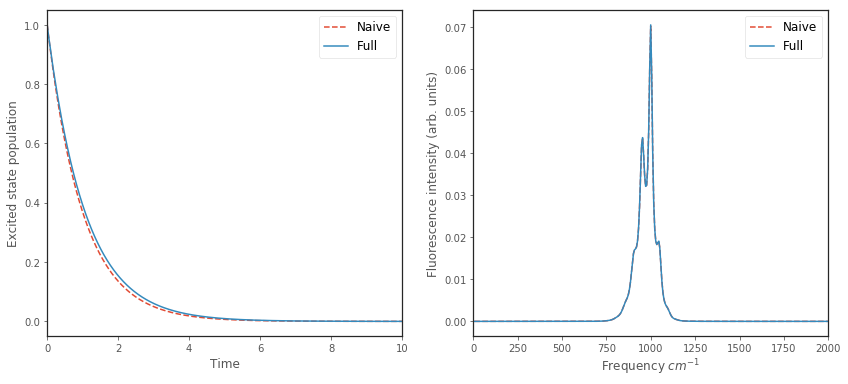

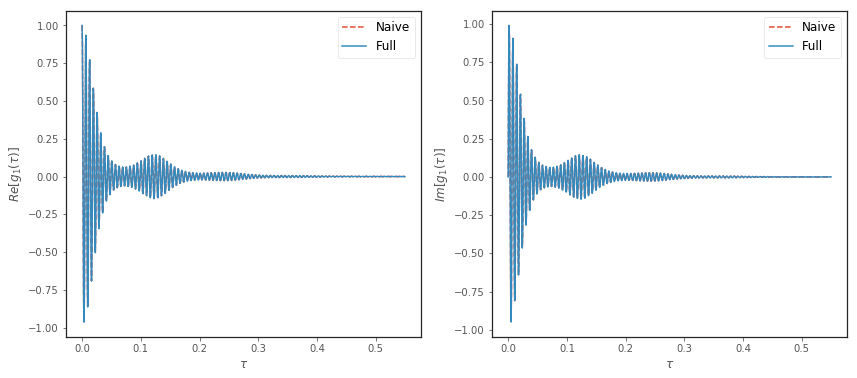

In [13]:

reload(SF)
alpha_prop = 0.05
w0_prop = 0.05
eps = 1000
print "eps is {} times the RC freq".format(1/w0_prop)
Gamma = eps*0.01
Gamma_EM = eps*0.001
print Gamma_EM
# beginning in a product state of |E> and non-displaced thermal state (that's what the first parameters mean)
freq, spec = emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=77., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=15)


### Emission: Lower $T_{ph}$

eps is 20.0 times the RC freq


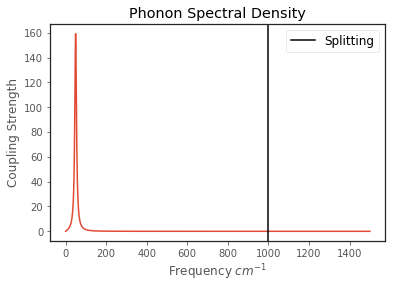

w_RC=50.0 | TLS splitting = 1000 | RC-res. coupling=0.03 | TLS-RC coupling=50.00 | Gamma_RC=10.00 | alpha_ph=31.83 | N=20 |
Completed initial dynamics calculations for Naive in 11.3144381046 seconds.
Completed correlation function calculations for Naive in 2.63095712662 seconds.
Completed initial dynamics calculations for Full in 13.3193480968 seconds.
Completed correlation function calculations for Full in 2.92482709885 seconds.


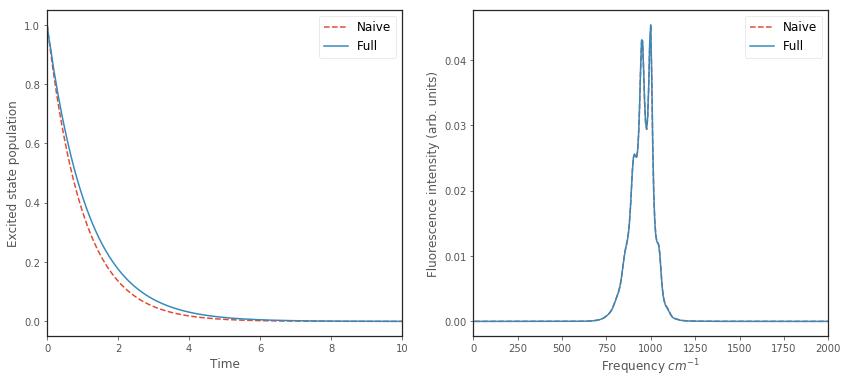

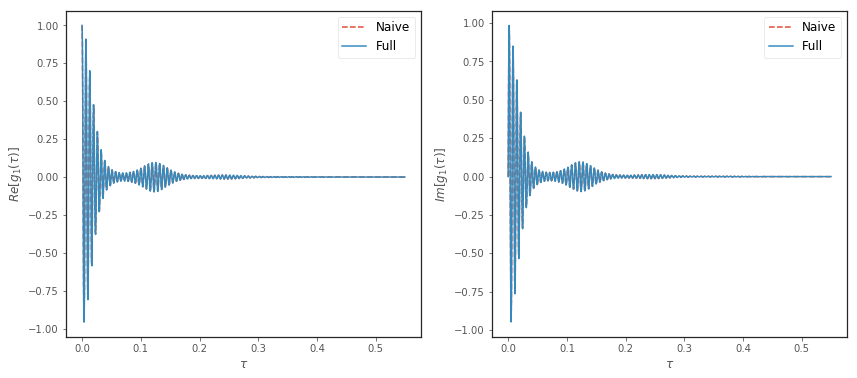

In [14]:
alpha_prop = 0.1
w0_prop = 0.05
eps = 1000
print "eps is {} times the RC freq".format(1/w0_prop)
Gamma = eps*0.01
Gamma_EM = eps*0.001
eps = 1000
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=45., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=20)

### Emission: smaller $\omega_0$ but larger $\alpha_1$

eps is 50.0 times the RC freq


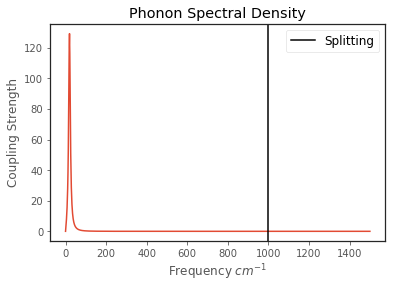

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.08 | TLS-RC coupling=44.72 | Gamma_RC=10.00 | alpha_ph=63.66 | N=27 |
Completed initial dynamics calculations for Naive in 59.9946351051 seconds.
Completed correlation function calculations for Naive in 6.48902606964 seconds.
Completed initial dynamics calculations for Full in 56.9160017967 seconds.
Completed correlation function calculations for Full in 5.45249986649 seconds.


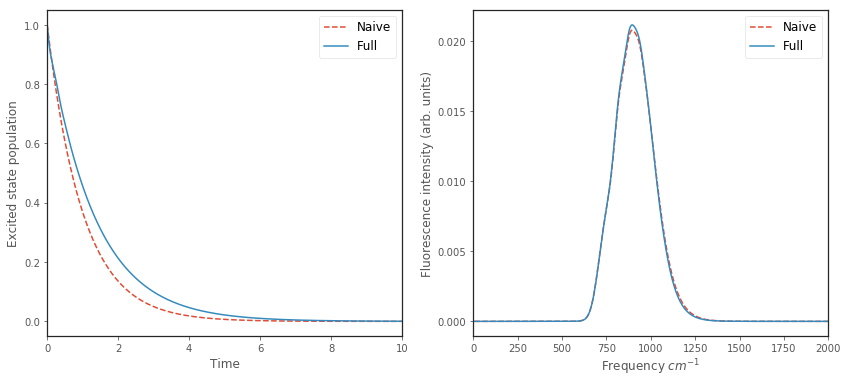

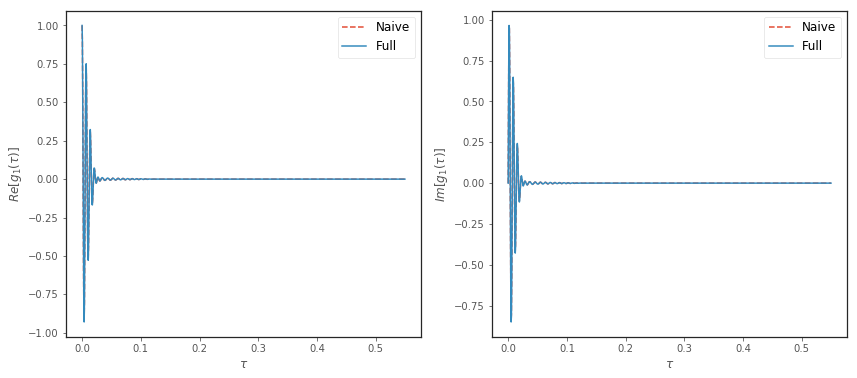

In [15]:
alpha_prop = 0.2
w0_prop = 0.02
print "eps is {} times the RC freq".format(1/w0_prop)
eps = 1000
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27)

From the above, there are minor changes in this intermediate-strong coupling regime, for low frequency modes. However, the number of states taken is rather small (there are 50 states until the first excited state)

eps is 50.0 times the RC freq


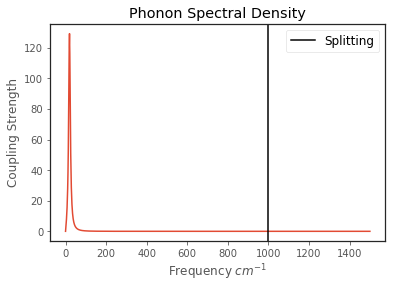

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.08 | TLS-RC coupling=44.72 | Gamma_RC=10.00 | alpha_ph=63.66 | N=27 |
Completed initial dynamics calculations for Naive in 31.0070509911 seconds.
Completed correlation function calculations for Naive in 7.31235599518 seconds.
Completed initial dynamics calculations for Full in 35.100673914 seconds.
Completed correlation function calculations for Full in 6.53607106209 seconds.


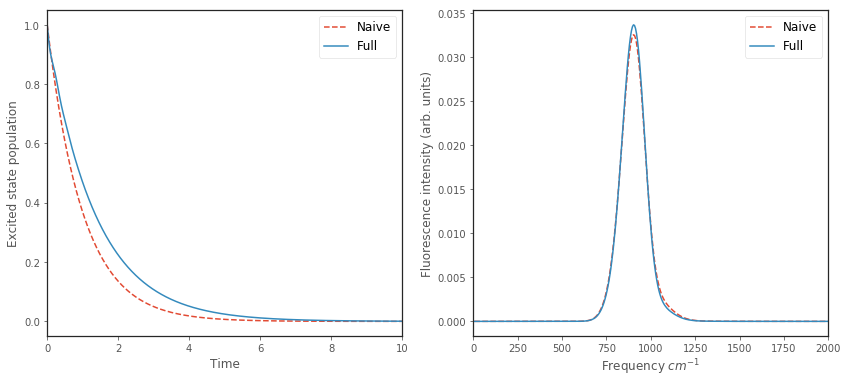

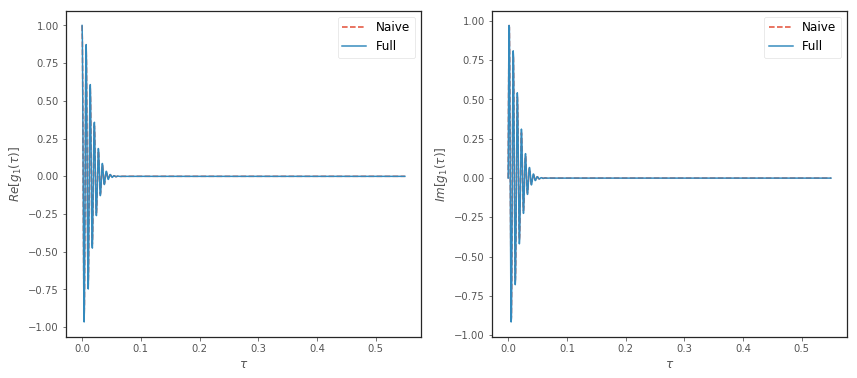

In [18]:
alpha_prop = 0.2
w0_prop = 0.02
print "eps is {} times the RC freq".format(1/w0_prop)
eps = 1000
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=25., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27)

check convergence of the previous plot

eps is 50.0 times the RC freq


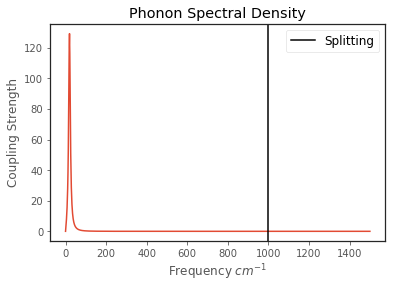

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.08 | TLS-RC coupling=44.72 | Gamma_RC=10.00 | alpha_ph=63.66 | N=35 |
Completed initial dynamics calculations for Naive in 59.6243739128 seconds.
Completed correlation function calculations for Naive in 21.5777461529 seconds.
Completed initial dynamics calculations for Full in 65.5812039375 seconds.
Completed correlation function calculations for Full in 17.7616739273 seconds.


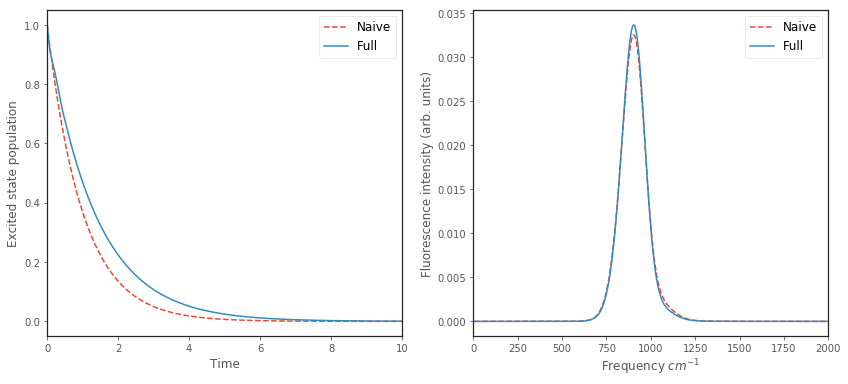

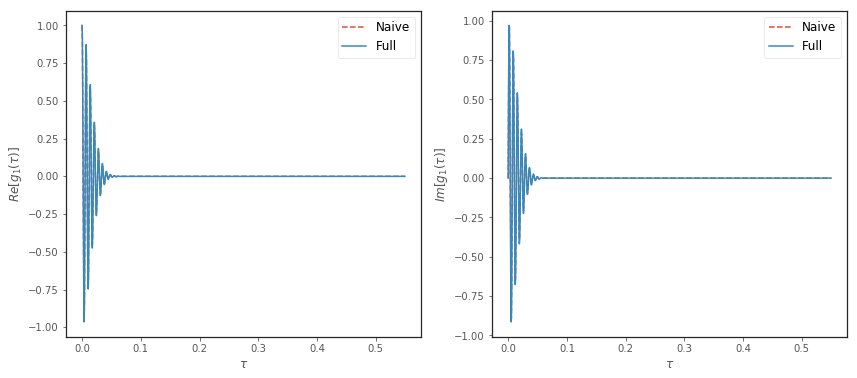

In [17]:
alpha_prop = 0.2
w0_prop = 0.02
print "eps is {} times the RC freq".format(1/w0_prop)
eps = 1000
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=25., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=35)

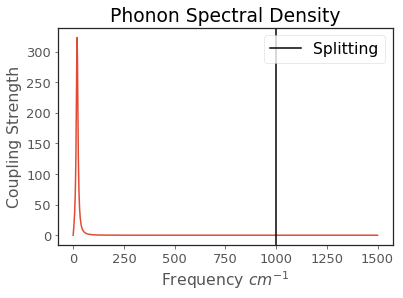

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.08 | TLS-RC coupling=70.71 | Gamma_RC=10.00 | alpha_ph=159.15 | N=27 |
Completed initial dynamics calculations for Naive in 108.050420046 seconds.
Completed correlation function calculations for Naive in 11.4769351482 seconds.
Completed initial dynamics calculations for Full in 119.560393095 seconds.
Completed correlation function calculations for Full in 12.3575100899 seconds.


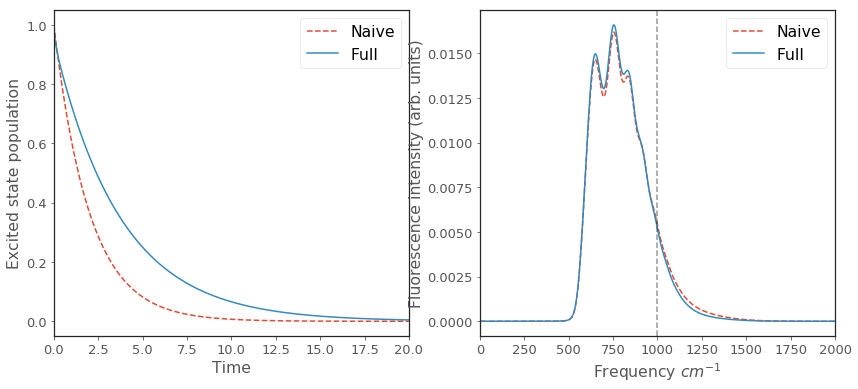

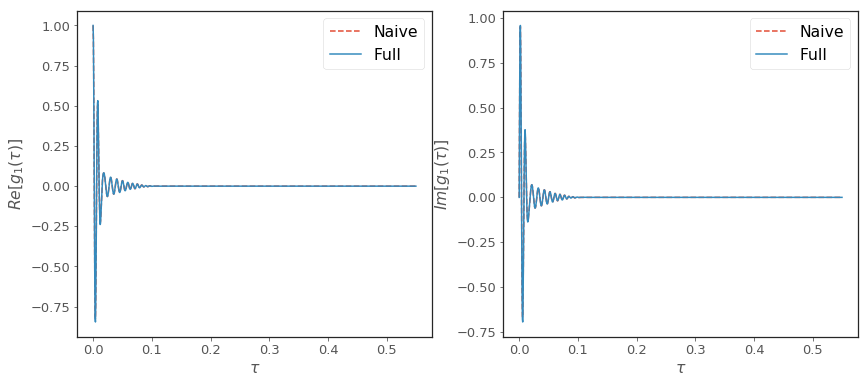

In [40]:
alpha_prop = 0.5
w0_prop = 0.02
eps = 1000
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27)

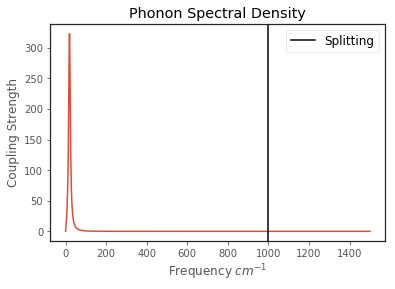

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.08 | TLS-RC coupling=70.71 | Gamma_RC=10.00 | alpha_ph=159.15 | N=38 |
Completed initial dynamics calculations for Naive in 247.858265877 seconds.
Completed correlation function calculations for Naive in 26.0641291142 seconds.
Completed initial dynamics calculations for Full in 250.421614885 seconds.
Completed correlation function calculations for Full in 30.3401827812 seconds.


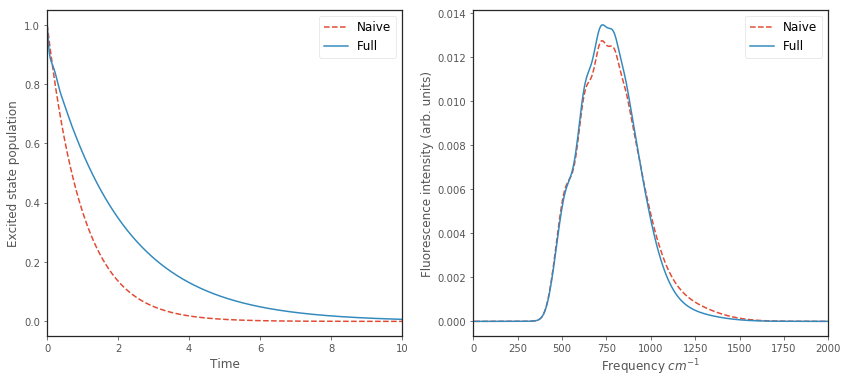

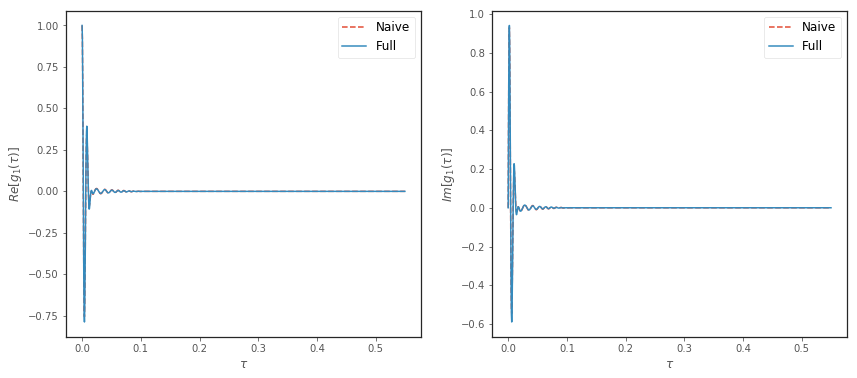

In [19]:
alpha_prop = 0.5
w0_prop = 0.02
eps = 1000
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=38)

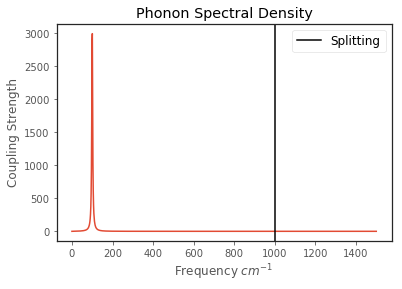

w_RC=100.0 | TLS splitting = 1000 | RC-res. coupling=0.01 | TLS-RC coupling=158.11 | Gamma_RC=5.00 | alpha_ph=159.15 | N=19 |
Completed initial dynamics calculations for Naive in 41.381909132 seconds.
Completed correlation function calculations for Naive in 3.43289995193 seconds.
Completed initial dynamics calculations for Full in 54.9468028545 seconds.
Completed correlation function calculations for Full in 4.51809692383 seconds.


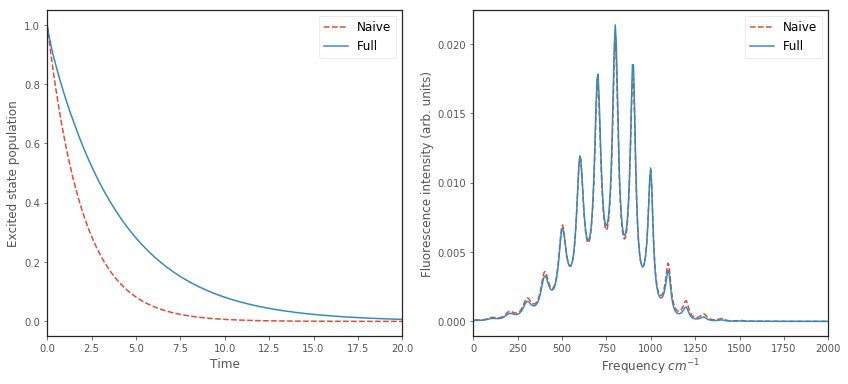

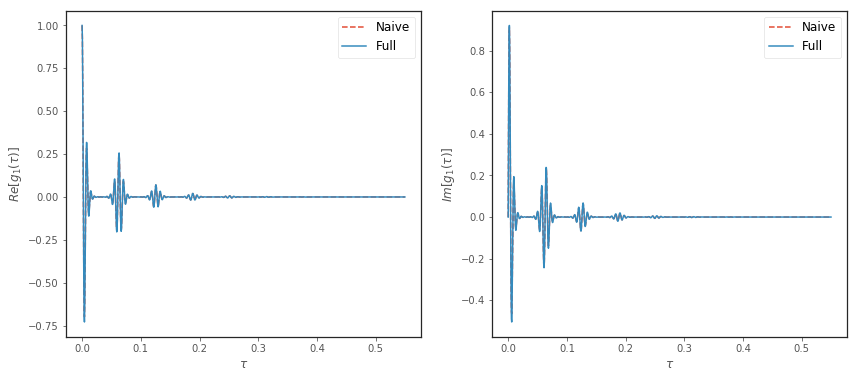

In [23]:
alpha_prop = 0.5
w0_prop = 0.1
eps = 1000
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=19)

16.6666666667


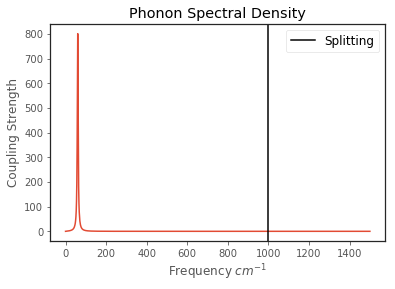

w_RC=60.0 | TLS splitting = 1000 | RC-res. coupling=0.01 | TLS-RC coupling=79.37 | Gamma_RC=5.00 | alpha_ph=66.85 | N=20 |
Completed initial dynamics calculations for Naive in 35.2304289341 seconds.
Completed correlation function calculations for Naive in 2.66073393822 seconds.
Completed initial dynamics calculations for Full in 35.003015995 seconds.
Completed correlation function calculations for Full in 3.49464702606 seconds.


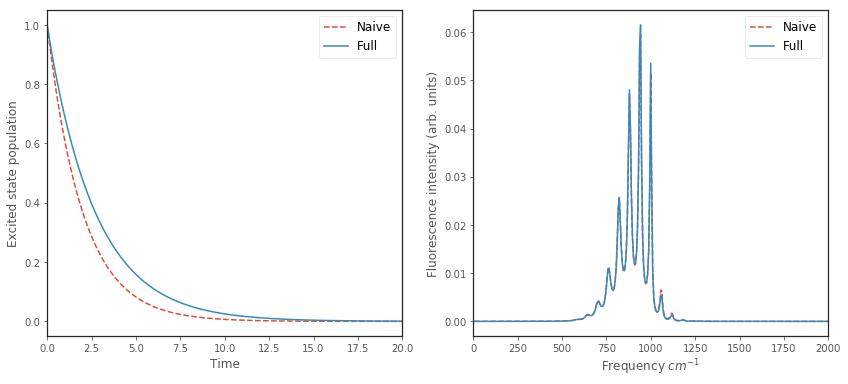

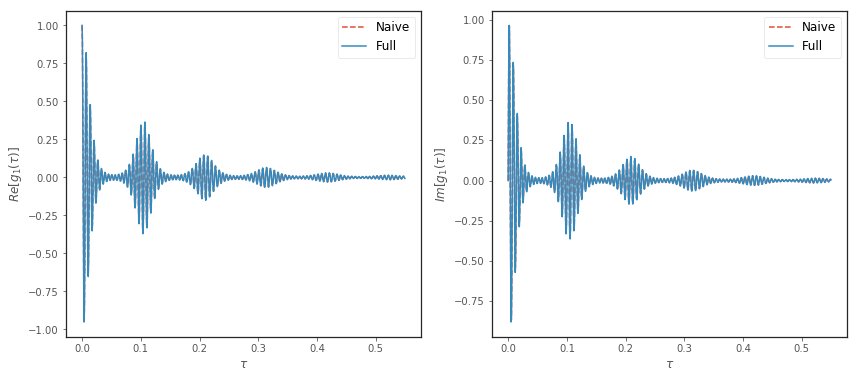

In [27]:
alpha_prop = 0.21
w0_prop = 0.06
print 1/w0_prop
eps = 1000
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=25., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=20)

The last calculations are slightly more interesting...

### Emission: smaller spontaneous emission and phonon broadening

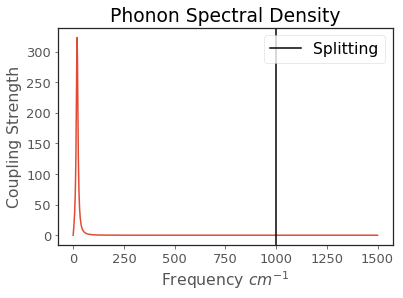

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.08 | TLS-RC coupling=70.71 | Gamma_RC=10.00 | alpha_ph=159.15 | N=27 |
Completed initial dynamics calculations for Naive in 103.544978142 seconds.
Completed correlation function calculations for Naive in 9.60875701904 seconds.
Completed initial dynamics calculations for Full in 115.829185963 seconds.
Completed correlation function calculations for Full in 14.7421360016 seconds.


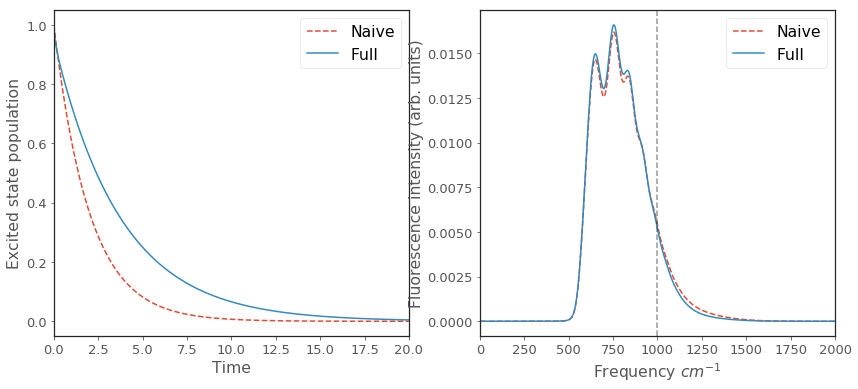

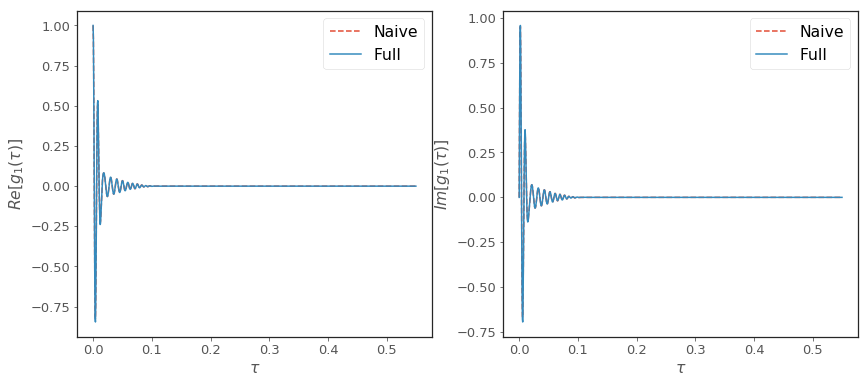

In [42]:
alpha_prop = 0.5
w0_prop = 0.02
eps = 1000
Gamma = eps*0.01
Gamma_EM = eps*0.0005
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27)

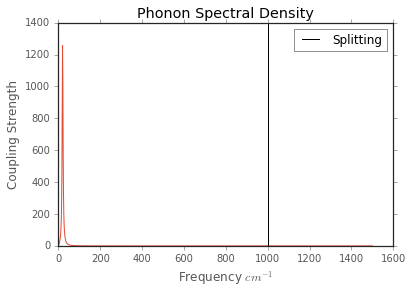

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.04 | TLS-RC coupling=100.00 | Gamma_RC=5.00 | alpha_ph=318.31 | N=27 |
Completed initial dynamics calculations for Naive in 84.2470109463 seconds.
Completed correlation function calculations for Naive in 8.75793814659 seconds.
Completed initial dynamics calculations for Full in 93.8188679218 seconds.
Completed correlation function calculations for Full in 10.8651258945 seconds.


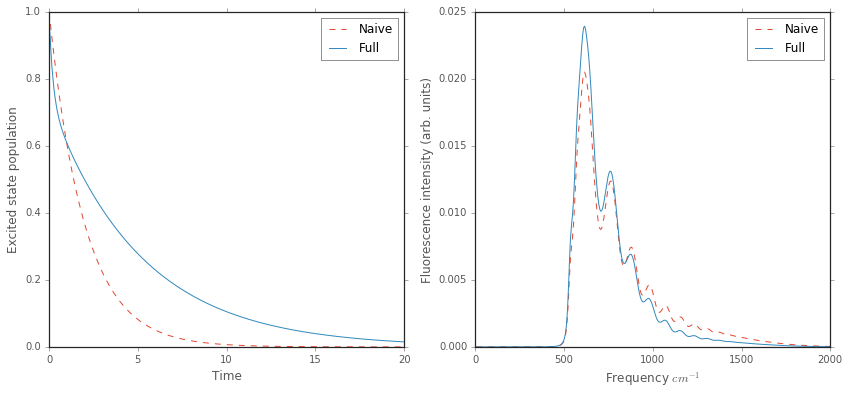

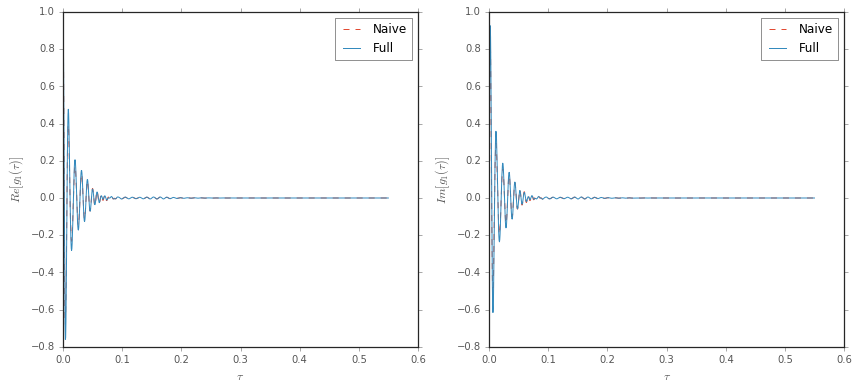

In [2]:
reload(SF)
alpha_prop = 1.
w0_prop = 0.02
eps = 1000
Gamma = eps*0.005
Gamma_EM = eps*0.0005
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27)

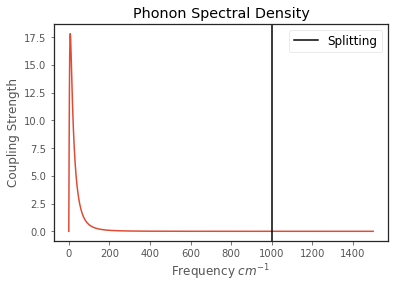

w_RC=20.0 | TLS splitting = 1000 | RC-res. coupling=0.48 | TLS-RC coupling=31.62 | Gamma_RC=60.49 | alpha_ph=31.83 | N=27 |
Completed initial dynamics calculations for Naive in 51.9058740139 seconds.
Completed correlation function calculations for Naive in 31.7289760113 seconds.
Completed initial dynamics calculations for Full in 50.1810450554 seconds.
Completed correlation function calculations for Full in 38.7844150066 seconds.


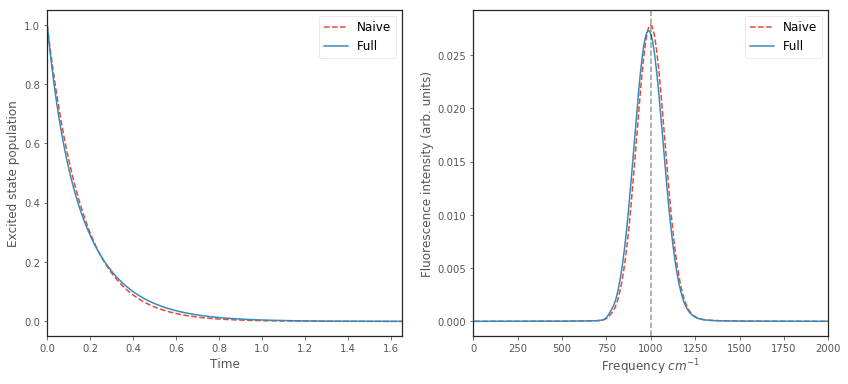

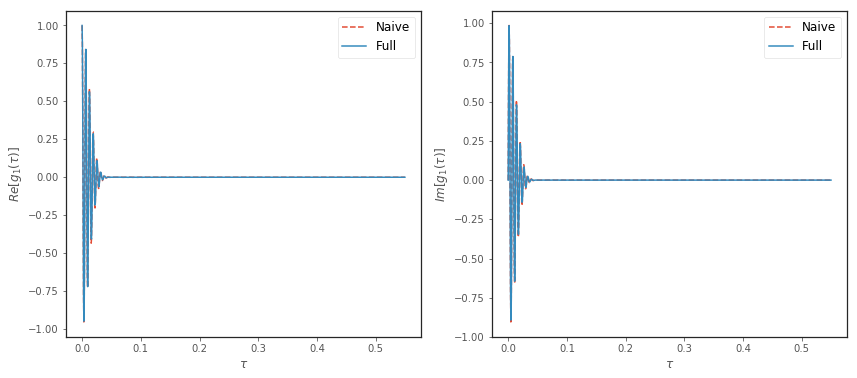

In [18]:
alpha_prop = 0.1
w0_prop = 0.02
eps = ev_to_inv_cm*1.5
Gamma = eps*0.005
Gamma_EM = eps*0.0005
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27)

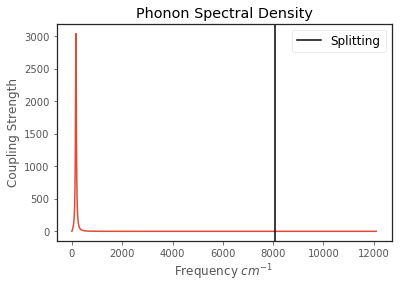

w_RC=161.31 | TLS splitting = 8065.5 | RC-res. coupling=0.04 | TLS-RC coupling=441.77 | Gamma_RC=40.33 | alpha_ph=770.20 | N=27 |
Completed initial dynamics calculations for Naive in 57.0613410473 seconds.
Completed correlation function calculations for Naive in 5.72468781471 seconds.
Completed initial dynamics calculations for Full in 65.8397397995 seconds.
Completed correlation function calculations for Full in 6.07505011559 seconds.


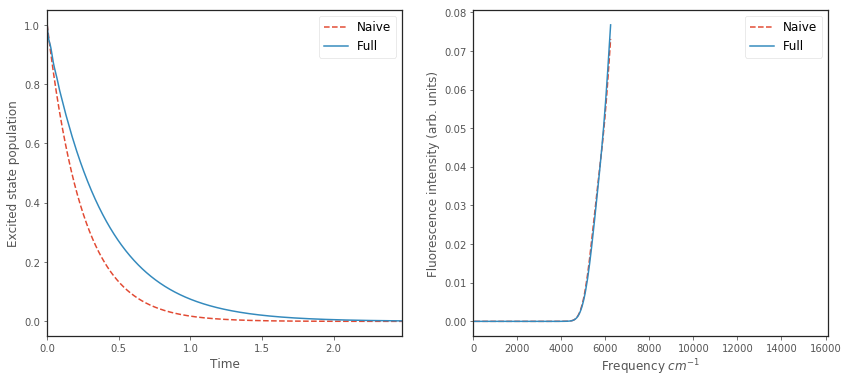

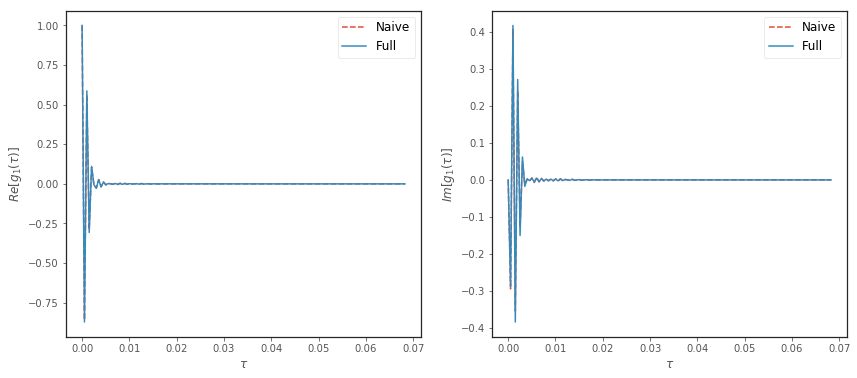

In [6]:
reload(SF)
alpha_prop = 0.3
w0_prop = 0.02
eps = ev_to_inv_cm*1.
Gamma = eps*0.005
Gamma_EM = eps*0.0005
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=27, tau_f_mult=0.125)

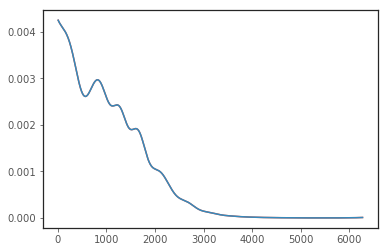

In [26]:
plt.plot(freq, spec)
plt.show()

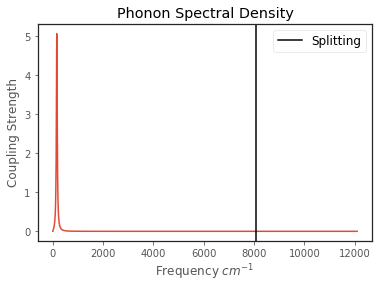

w_RC=161.31 | TLS splitting = 8065.5 | RC-res. coupling=0.04 | TLS-RC coupling=18.04 | Gamma_RC=40.33 | alpha_ph=1.28 | N=10 |
Completed initial dynamics calculations for Naive in 0.956996917725 seconds.
Completed correlation function calculations for Naive in 3.2286939621 seconds.
Completed initial dynamics calculations for Full in 1.13579297066 seconds.
Completed correlation function calculations for Full in 3.52195096016 seconds.


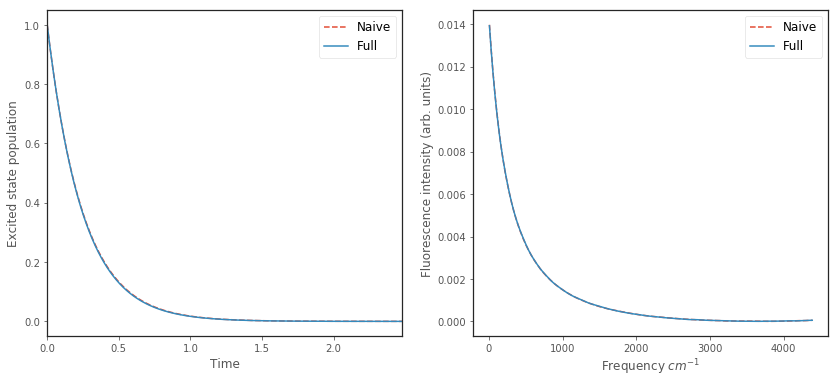

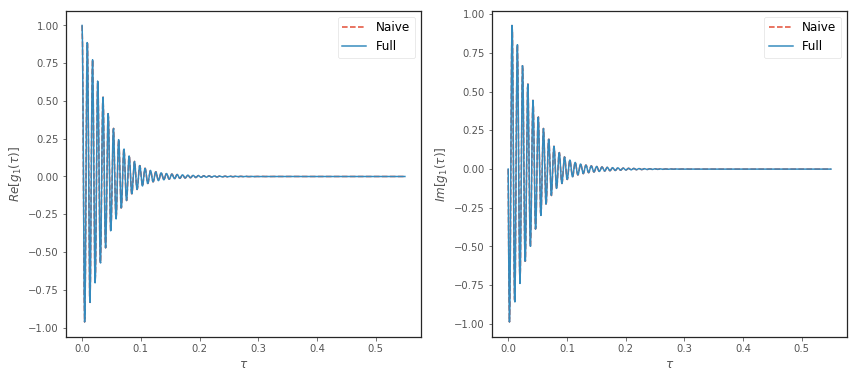

In [25]:

reload(SF)
alpha_prop = 0.0005
w0_prop = 0.02
eps = ev_to_inv_cm*1.
Gamma = eps*0.005
Gamma_EM = eps*0.0005
freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=10, tau_f_mult=1., per_tau=0.7)

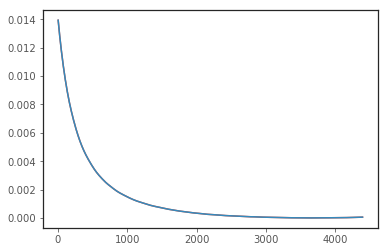

In [27]:
plt.plot(freq, spec)
plt.show()

## Emission: much higher $\omega_0$

note that $g_1(\tau)$ is calculated for twice as long as is shown on the axes. I expect that the spectra will agree much more in this parameter regime.

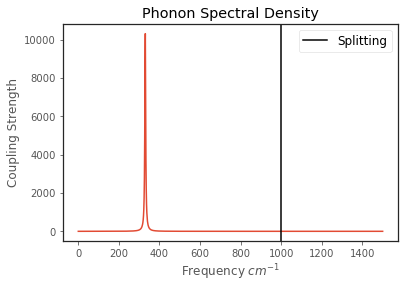

w_RC=330.0 | TLS splitting = 1000 | RC-res. coupling=0.00 | TLS-RC coupling=287.23 | Gamma_RC=5.00 | alpha_ph=159.15 | N=14 |
Completed initial dynamics calculations for Naive in 39.5174250603 seconds.
Completed correlation function calculations for Naive in 10.9831750393 seconds.
Completed initial dynamics calculations for Full in 59.4871919155 seconds.
Completed correlation function calculations for Full in 18.0676279068 seconds.


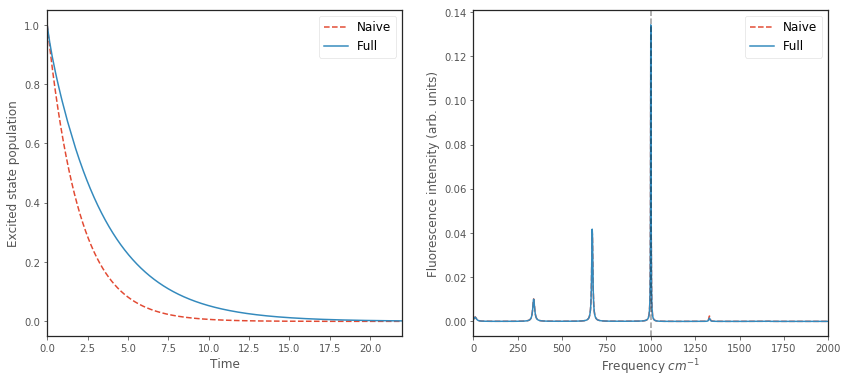

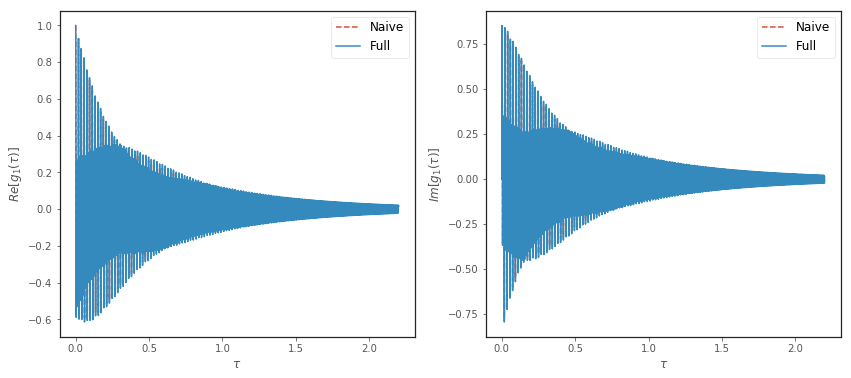

In [14]:
reload(SF)
alpha_prop = 0.5
w0_prop = 0.33
eps = 1000
Gamma = eps*0.005
Gamma_EM = eps*0.0005


freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=14, end_T_mult=11, tau_f_mult=4.)

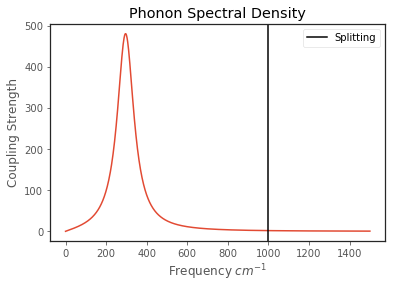

w_RC=300.0 | TLS splitting = 1000 | RC-res. coupling=0.05 | TLS-RC coupling=273.86 | Gamma_RC=100.00 | alpha_ph=159.15 | N=12 |
Completed initial dynamics calculations for Naive in 11.1509330273 seconds.
Completed correlation function calculations for Naive in 1.65879893303 seconds.
Completed initial dynamics calculations for Full in 15.4421069622 seconds.
Completed correlation function calculations for Full in 1.92984294891 seconds.


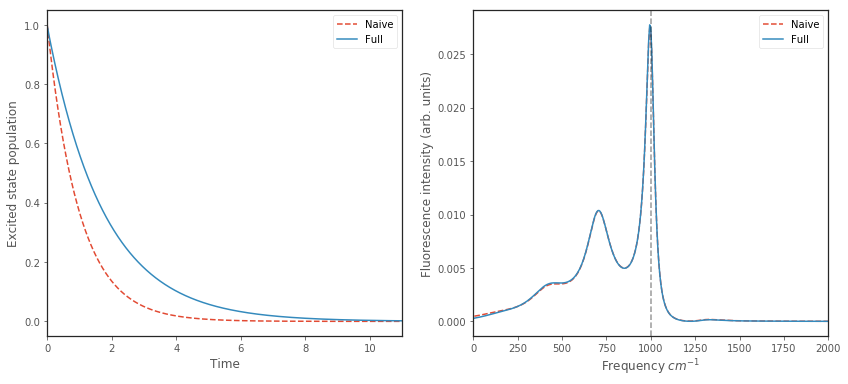

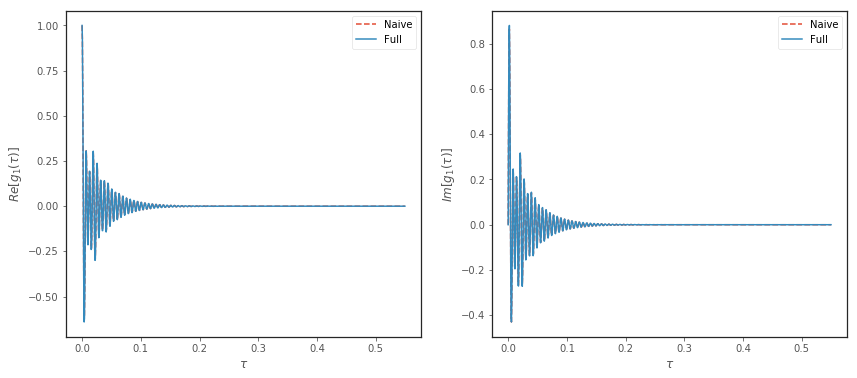

In [25]:
reload(SF)
alpha_prop = 0.5
w0_prop = 0.3
Gamma = eps*0.1
Gamma_EM = eps*0.001
eps = 1000

freq, spec = SF.emission_spectra(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_ph=77., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=12, end_T_mult=11)

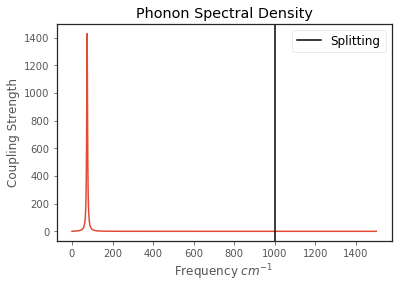

w_RC=75.0 | TLS splitting = 1000 | RC-res. coupling=0.01 | TLS-RC coupling=106.07 | Gamma_RC=5.00 | alpha_ph=95.49 | N=14 |
Completed initial dynamics calculations for Naive in 12.3327441216 seconds.
Completed correlation function calculations for Naive in 1.67038106918 seconds. Final value was 0.011+0.003j.
Completed initial dynamics calculations for Full in 13.1319849491 seconds.
Completed correlation function calculations for Full in 1.99560904503 seconds. Final value was 0.014+0.003j.
w_RC=75.0 | TLS splitting = 1000 | RC-res. coupling=0.01 | TLS-RC coupling=106.07 | Gamma_RC=5.00 | alpha_ph=95.49 | N=14 |
Completed initial dynamics calculations for Naive in 12.3329980373 seconds.
Completed correlation function calculations for Naive in 1.94236302376 seconds. Final value was 0.000+0.000j.
Completed initial dynamics calculations for Full in 12.4141538143 seconds.
Completed correlation function calculations for Full in 3.31222391129 seconds. Final value was 0.000+0.000j.
w_RC=75.0 | 

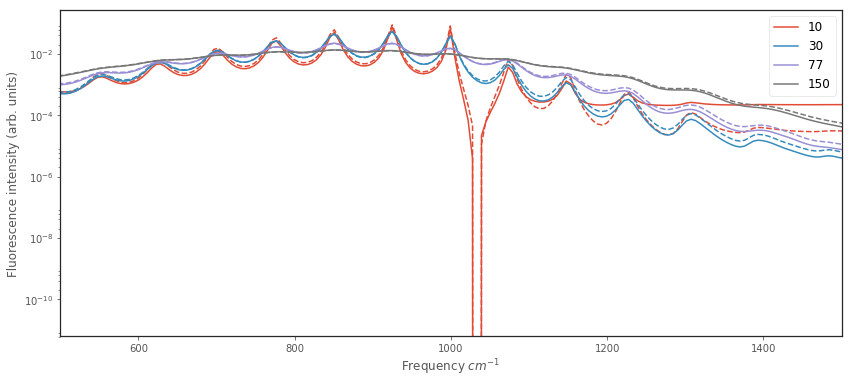

In [44]:
def emission_spectra_Tdep(init_sys, init_RC, prop_coupling, eps, Gamma, w0_prop=2.1,
                          T_vals = [10, 30, 77, 150], T_EM=0.,Gamma_EM=1., overdamped=False, N=9,
                    end_T_mult=10, tau_f_mult=1., per_tau=1. , log_y=True):
    wc = 53.
    # Start system+RC in adiabatic eigenstate and then time-evolve
    plt.close('all')
    alpha_ph = prop_coupling*eps/pi
    w0 = eps*w0_prop
    if overdamped:
        Gamma = (w0**2)/wc
    else:
        #N=20
        pass
    w = np.linspace(0., eps*1.5, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma, w0))
    plt.axvline(eps, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    G = ket([0])
    E = ket([1])
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = J_multipolar
    count = 1
    I_RC = qt.qeye(N)
    f1, ax1 = plt.subplots(1, 1, figsize=(14,6))
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dyn_DATA = []
    for j, T_ph in enumerate(T_vals):
        L_RC, H_RC, A_EM, A_nrwa, Z, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps,
                                                                       T_ph, Gamma,
                                                                       w0, alpha_ph, N, rotating=False)
        evals, states = H_RC.eigenstates()
        ground_list, excited_list = ground_and_excited_states(states)
        # work out how to initialise system rho
        init_rho = initialise_TLS(init_sys, init_RC, states, w0, T_ph)
        label = ['Naive', 'Full']
        #print len(excited_list), 'excited'
        # electromagnetic bath liouvillians
        final_t = end_T_mult/Gamma_EM
        timelist = np.linspace(0,final_t,int(380*final_t))
        options = qt.Options(nsteps=6000, store_states=True)
        

        E_op = tensor(E*E.dag(), I_RC)
        if overdamped:
                steps_per_tau, tau_f = 1500*per_tau,  1.1
        else:
            if abs((w0-eps)/eps)<0.1:
                steps_per_tau, tau_f = 2000*per_tau, 2.5
            else:
                steps_per_tau, tau_f = 2000*per_tau, 1.1
        tau_f*=tau_f_mult
        for i, L_EM in enumerate([EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J, silent=True),
                            EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J, silent=True)]):
            #L_EM = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
            #L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
            ti = time.time()
            sigma_RC = tensor(sigma, I_RC)

            if label[i]=='Full':
                sigma_plus_RC, sigma_RC, sigma_0_RC = EM.RWA_system_ops(H_RC, tensor(sigma+sigma.dag(), I_RC))
                ls = 'solid'
            else:
                ls = 'dashed'
            P = mesolve(H_RC, init_rho, timelist, [L_RC+L_EM], progress_bar=None,options=options).states
            
            #norm = np.array([(sigma_RC.dag()*sigma_RC*rho_t).tr() for rho_t in P])[0:tau_f*steps_per_tau]
            R= sum(P)
            print "Completed initial dynamics calculations for {} in {} seconds.".format(label[i], time.time()-ti)
            ti = time.time()
            Lambda_0 = sigma_RC*R
            del P
            taulist = np.linspace(0, tau_f, int(tau_f*steps_per_tau))
            Lambda_t = mesolve(H_RC, Lambda_0, taulist, [L_RC+L_EM],options=options)
            #sigma_t = mesolve(H_RC, init_rho, taulist, [L_RC+L_EM],
            #                  [sigma_RC.dag()*sigma_RC], options=options).expect[0]
            g_1 = np.array([(sigma_RC.dag()*l).tr() for l in Lambda_t.states])
            g_1/=abs(g_1[0])
            #else:
            #    g_1/=np.sqrt(norm*norm[0])

            #if label[i] == 'Full':
            #    g_1=g_1.conjugate()
            freq, spec = qt.spectrum_correlation_fft(taulist, g_1)
            spec-= min(spec)
            spec = spec/sum(spec)
            if i==1:
                # only label one of the two calculations
                ax1.plot(freq, spec.real, label=int(T_ph), linestyle=ls, color=colors[j])
            else:
                ax1.plot(freq, spec.real, linestyle=ls, color=colors[j])
            print "Completed correlation function calculations for {} in {} seconds. Final value was {:.3f}.".format(
                                                                            label[i], time.time()-ti, g_1[-1])

    ax1.set_xlabel(r"Frequency $cm^{-1}$")
    #ax2.axvline(eps, linestyle='dashed',color='k', alpha=0.4)
    ax1.set_xlim(eps*0.5,eps*1.5)
    ax1.set_ylabel(r"Fluorescence intensity (arb. units)")
    if log_y:
        ax1.set_yscale('log')
    ax1.legend()
    plt.show()
    return freq, spec

alpha_prop = 0.3
w0_prop = 0.075
eps = 1000
freq, spec = emission_spectra_Tdep(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=14, per_tau=0.96, log_y=True)

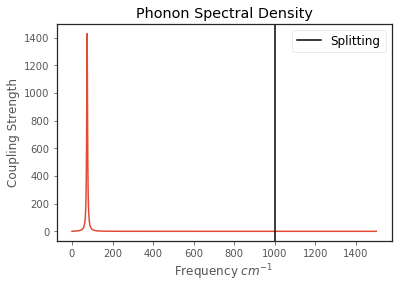

w_RC=75.0 | TLS splitting = 1000 | RC-res. coupling=0.01 | TLS-RC coupling=106.07 | Gamma_RC=5.00 | alpha_ph=95.49 | N=14 |
Completed initial dynamics calculations for Naive in 11.7108280659 seconds.
Completed correlation function calculations for Naive in 1.36212897301 seconds. Final value was 0.011+0.003j.
Completed initial dynamics calculations for Full in 13.4797258377 seconds.
Completed correlation function calculations for Full in 2.12438607216 seconds. Final value was 0.014+0.003j.
w_RC=75.0 | TLS splitting = 1000 | RC-res. coupling=0.01 | TLS-RC coupling=106.07 | Gamma_RC=5.00 | alpha_ph=95.49 | N=14 |
Completed initial dynamics calculations for Naive in 11.9025788307 seconds.
Completed correlation function calculations for Naive in 1.37391805649 seconds. Final value was 0.000+0.000j.
Completed initial dynamics calculations for Full in 13.7759320736 seconds.
Completed correlation function calculations for Full in 1.84198498726 seconds. Final value was 0.000+0.000j.
w_RC=75.0 | 

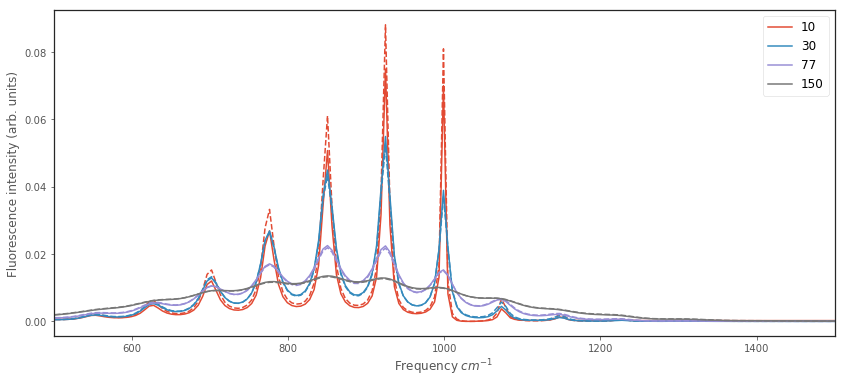

In [43]:
freq, spec = emission_spectra_Tdep(2, 0, alpha_prop, eps, Gamma, w0_prop=w0_prop, T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=False, N=14, per_tau=0.90)

## Absorption spectra
This remains to be done. I need to look over the calculation again but it's not really on my agenda right now...

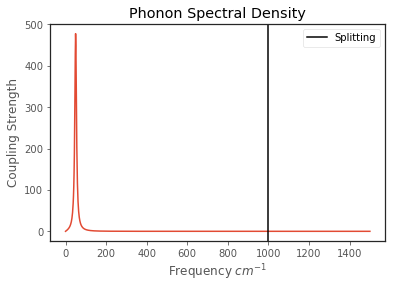

w_RC=50.0 | TLS splitting = 1000 | RC-res. coupling=0.03 | TLS-RC coupling=86.60 | Gamma_RC=10.00 | alpha_ph=95.49 | N=15 |
Completed response function calculations for Naive in 2.42631196976 seconds.
Completed response function calculations for Full in 2.37483692169 seconds.


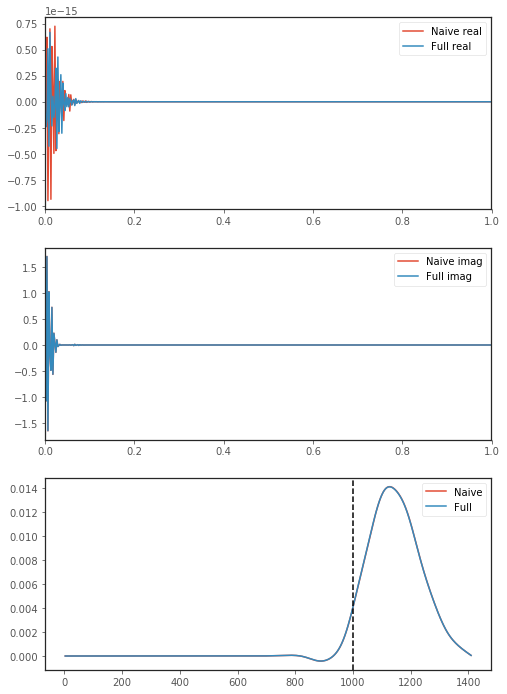

In [36]:
reload(SF)
alpha_prop = 0.3
w0_prop = 0.05
eps = 1000
Gamma = eps*0.01
Gamma_EM = eps*0.001
freq, spec = SF.absorption_spectra(alpha_prop, eps, Gamma, w0_prop*eps, Gamma_EM=Gamma_EM, overdamped=False, N=15)